In [1]:
```python
# Mount Google Drive and install dependencies
from google.colab import drive
drive.mount('/content/drive')
!pip install -q mne torch pytorch-lightning matplotlib ipywidgets

import os
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import mne
from mne.preprocessing import ICA
from scipy.signal import welch
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from urllib.request import urlretrieve
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
pl.seed_everything(42)

# Download and preprocess datasets
def download_physionet_eeg():
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40)
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

def download_neurotycho_ecog():
    if not os.path.exists('ecog_data'):
        os.makedirs('ecog_data')
        url = "http://neurotycho.org/data/20100412S1_K1B1_Anesthesia+and+Sleep_Task_ECoG128_GroundTruth.mat"
        urlretrieve(url, 'ecog_data/ecog.mat')
    # Simulate ECoG loading (NeuroTycho is complex, using subset)
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)  # Placeholder
    raw.filter(1, 40)
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

# Custom Dataset
class BCIDataset(Dataset):
    def __init__(self, data):
        self.data = StandardScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
        self.data = torch.FloatTensor(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        signal = self.data[idx]
        # Add synthetic noise for self-supervised training
        noise = torch.randn_like(signal) * 0.1
        noisy_signal = signal + noise
        return noisy_signal, signal

# 1D Transformer Autoencoder
class TransformerAutoencoder(nn.Module):
    def __init__(self, n_channels=64, n_timesteps=320, d_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.input_proj = nn.Linear(n_channels, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dimlottery=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_proj = nn.Linear(d_model, n_channels)

    def forward(self, x):
        x = x.permute(2, 0, 1)  # (batch, channels, time) -> (time, batch, channels)
        x = self.input_proj(x)
        x = self.encoder(x)
        x = self.output_proj(x)
        return x.permute(1, 2, 0)  # (time, batch, channels) -> (batch, channels, time)

# PyTorch Lightning Module
class BCIDenoiser(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = TransformerAutoencoder()
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return [optimizer], [scheduler]

# SNR calculation
def calculate_snr(signal, denoised):
    noise = signal - denoised
    return 10 * np.log10(np.var(signal) / np.var(noise))

# ICA baseline
def ica_denoise(data):
    raw = mne.io.RawArray(data.T, mne.create_info(64, 160, 'eeg'))
    ica = ICA(n_components=15, random_state=42).fit(raw)
    raw_clean = ica.apply(raw.copy())
    return raw_clean.get_data().T

# Dashboard
def plot_results(eeg_data, ecog_data, model):
    model.eval()
    with torch.no_grad():
        eeg_noisy = torch.FloatTensor(eeg_data[:10]).cuda()
        eeg_denoised = model(eeg_noisy).cpu().numpy()
        ecog_noisy = torch.FloatTensor(ecog_data[:10]).cuda()
        ecog_denoised = model(ecog_noisy).cpu().numpy()

    eeg_ica = ica_denoise(eeg_data[:10])
    ecog_ica = ica_denoise(ecog_data[:10])

    eeg_snr = np.mean([calculate_snr(eeg_data[i], eeg_denoised[i]) for i in range(10)])
    ecog_snr = np.mean([calculate_snr(ecog_data[i], ecog_denoised[i]) for i in range(10)])
    eeg_snr_ica = np.mean([calculate_snr(eeg_data[i], eeg_ica[i]) for i in range(10)])
    ecog_snr_ica = np.mean([calculate_snr(ecog_data[i], ecog_ica[i]) for i in range(10)])

    def plot_interactive(epoch):
        plt.figure(figsize=(15, 8))
        plt.subplot(2, 2, 1)
        plt.plot(eeg_noisy[epoch, 0].cpu().numpy(), label='Noisy EEG')
        plt.plot(eeg_denoised[epoch, 0], label='Denoised EEG')
        plt.title(f'EEG (SNR: {eeg_snr:.2f} dB vs ICA: {eeg_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(ecog_noisy[epoch, 0].cpu().numpy(), label='Noisy ECoG')
        plt.plot(ecog_denoised[epoch, 0], label='Denoised ECoG')
        plt.title(f'ECoG (SNR: {ecog_snr:.2f} dB vs ICA: {ecog_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 3)
        f, pxx = welch(eeg_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy EEG PSD')
        f, pxx = welch(eeg_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised EEG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.subplot(2, 2, 4)
        f, pxx = welch(ecog_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy ECoG PSD')
        f, pxx = welch(ecog_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised ECoG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.tight_layout()
        plt.show()

    interact(plot_interactive, epoch=IntSlider(min=0, max=9, step=1, value=0))

# Main execution
def main():
    # Load data
    eeg_data = download_physionet_eeg()
    ecog_data = download_neurotycho_ecog()

    # Create datasets and dataloaders
    eeg_dataset = BCIDataset(eeg_data)
    ecog_dataset = BCIDataset(ecog_data)
    eeg_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=True, num_workers=2)
    ecog_loader = DataLoader(ecog_dataset, batch_size=32, num_workers=2)

    # Initialize model and trainer
    model = BCIDenoiser()
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath='/content/drive/MyDrive/BCI_ckpt',
        monitor='val_loss',
        filename='denoiser-{epoch:02d}-{val_loss:.2f}',
        save_last=True
    )

    trainer = pl.Trainer(
        max_epochs=5,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        callbacks=[checkpoint_callback],
        resume_from_checkpoint='/content/drive/MyDrive/BCI_ckpt/last.ckpt' if os.path.exists('/content/drive/MyDrive/BCI_ckpt/last.ckpt') else None
    )

    # Pre-train on EEG
    trainer.fit(model, eeg_loader, eeg_loader)

    # Fine-tune on ECoG
    trainer.fit(model, ecog_loader, ecog_loader)

    # Visualize results
    plot_results(eeg_data, ecog_data, model)

if __name__ == '__main__':
    main()
```

SyntaxError: invalid syntax (<ipython-input-1-84f1cfe15a3b>, line 1)

In [1]:
# Mount Google Drive and install dependencies
from google.colab import drive
drive.mount('/content/drive')
!pip install -q mne torch pytorch-lightning matplotlib ipywidgets

import os
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import mne
from mne.preprocessing import ICA
from scipy.signal import welch
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from urllib.request import urlretrieve
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
pl.seed_everything(42)

# Download and preprocess datasets
def download_physionet_eeg():
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40)
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

def download_neurotycho_ecog():
    if not os.path.exists('ecog_data'):
        os.makedirs('ecog_data')
        url = "http://neurotycho.org/data/20100412S1_K1B1_Anesthesia+and+Sleep_Task_ECoG128_GroundTruth.mat"
        urlretrieve(url, 'ecog_data/ecog.mat')
    # Simulate ECoG loading (NeuroTycho is complex, using subset)
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)  # Placeholder
    raw.filter(1, 40)
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

# Custom Dataset
class BCIDataset(Dataset):
    def __init__(self, data):
        self.data = StandardScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
        self.data = torch.FloatTensor(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        signal = self.data[idx]
        # Add synthetic noise for self-supervised training
        noise = torch.randn_like(signal) * 0.1
        noisy_signal = signal + noise
        return noisy_signal, signal

# 1D Transformer Autoencoder
class TransformerAutoencoder(nn.Module):
    def __init__(self, n_channels=64, n_timesteps=320, d_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.input_proj = nn.Linear(n_channels, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=512)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_proj = nn.Linear(d_model, n_channels)

    def forward(self, x):
        x = x.permute(2, 0, 1)  # (batch, channels, time) -> (time, batch, channels)
        x = self.input_proj(x)
        x = self.encoder(x)
        x = self.output_proj(x)
        return x.permute(1, 2, 0)  # (time, batch, channels) -> (batch, channels, time)

# PyTorch Lightning Module
class BCIDenoiser(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = TransformerAutoencoder()
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return [optimizer], [scheduler]

# SNR calculation
def calculate_snr(signal, denoised):
    noise = signal - denoised
    return 10 * np.log10(np.var(signal) / np.var(noise))

# ICA baseline
def ica_denoise(data):
    raw = mne.io.RawArray(data.T, mne.create_info(64, 160, 'eeg'))
    ica = ICA(n_components=15, random_state=42).fit(raw)
    raw_clean = ica.apply(raw.copy())
    return raw_clean.get_data().T

# Dashboard
def plot_results(eeg_data, ecog_data, model):
    model.eval()
    with torch.no_grad():
        eeg_noisy = torch.FloatTensor(eeg_data[:10]).cuda()
        eeg_denoised = model(eeg_noisy).cpu().numpy()
        ecog_noisy = torch.FloatTensor(ecog_data[:10]).cuda()
        ecog_denoised = model(ecog_noisy).cpu().numpy()

    eeg_ica = ica_denoise(eeg_data[:10])
    ecog_ica = ica_denoise(ecog_data[:10])

    eeg_snr = np.mean([calculate_snr(eeg_data[i], eeg_denoised[i]) for i in range(10)])
    ecog_snr = np.mean([calculate_snr(ecog_data[i], ecog_denoised[i]) for i in range(10)])
    eeg_snr_ica = np.mean([calculate_snr(eeg_data[i], eeg_ica[i]) for i in range(10)])
    ecog_snr_ica = np.mean([calculate_snr(ecog_data[i], ecog_ica[i]) for i in range(10)])

    def plot_interactive(epoch):
        plt.figure(figsize=(15, 8))
        plt.subplot(2, 2, 1)
        plt.plot(eeg_noisy[epoch, 0].cpu().numpy(), label='Noisy EEG')
        plt.plot(eeg_denoised[epoch, 0], label='Denoised EEG')
        plt.title(f'EEG (SNR: {eeg_snr:.2f} dB vs ICA: {eeg_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(ecog_noisy[epoch, 0].cpu().numpy(), label='Noisy ECoG')
        plt.plot(ecog_denoised[epoch, 0], label='Denoised ECoG')
        plt.title(f'ECoG (SNR: {ecog_snr:.2f} dB vs ICA: {ecog_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 3)
        f, pxx = welch(eeg_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy EEG PSD')
        f, pxx = welch(eeg_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised EEG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.subplot(2, 2, 4)
        f, pxx = welch(ecog_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy ECoG PSD')
        f, pxx = welch(ecog_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised ECoG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.tight_layout()
        plt.show()

    interact(plot_interactive, epoch=IntSlider(min=0, max=9, step=1, value=0))

# Main execution
def main():
    # Load data
    eeg_data = download_physionet_eeg()
    ecog_data = download_neurotycho_ecog()

    # Create datasets and dataloaders
    eeg_dataset = BCIDataset(eeg_data)
    ecog_dataset = BCIDataset(ecog_data)
    eeg_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=True, num_workers=2)
    ecog_loader = DataLoader(ecog_dataset, batch_size=32, num_workers=2)

    # Initialize model and trainer
    model = BCIDenoiser()
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath='/content/drive/MyDrive/BCI_ckpt',
        monitor='val_loss',
        filename='denoiser-{epoch:02d}-{val_loss:.2f}',
        save_last=True
    )

    trainer = pl.Trainer(
        max_epochs=5,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        callbacks=[checkpoint_callback],
        resume_from_checkpoint='/content/drive/MyDrive/BCI_ckpt/last.ckpt' if os.path.exists('/content/drive/MyDrive/BCI_ckpt/last.ckpt') else None
    )

    # Pre-train on EEG
    trainer.fit(model, eeg_loader, eeg_loader)

    # Fine-tune on ECoG
    trainer.fit(model, ecog_loader, ecog_loader)

    # Visualize results
    plot_results(eeg_data, ecog_data, model)

if __name__ == '__main__':
    main()

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

INFO:lightning_fabric.utilities.seed:Seed set to 42


Extracting EDF parameters from /content/eeg_data/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)

Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 320 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Extracting EDF parameters from /content/eeg_data/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)

Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 320 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


TypeError: Trainer.__init__() got an unexpected keyword argument 'resume_from_checkpoint'

In [2]:
# Mount Google Drive and install dependencies
from google.colab import drive
drive.mount('/content/drive')
!pip install -q mne torch pytorch-lightning matplotlib ipywidgets

import os
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import mne
from mne.preprocessing import ICA
from scipy.signal import welch
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from urllib.request import urlretrieve
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
pl.seed_everything(42)

# Download and preprocess datasets
def download_physionet_eeg():
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40)
    epochs = mne.make intercal_length_epochs(raw, duration=2.0)
    return epochs.get_data()

def download_neurotycho_ecog():
    # Simulate ECoG using PhysioNet with added noise for differentiation
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40)
    # Add synthetic noise to simulate ECoG characteristics
    data = raw.get_data()
    noise = np.random.normal(0, 0.2, data.shape)
    raw._data += noise
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

# Custom Dataset
class BCIDataset(Dataset):
    def __init__(self, data):
        self.data = StandardScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
        self.data = torch.FloatTensor(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        signal = self.data[idx]
        # Add synthetic noise for self-supervised training
        noise = torch.randn_like(signal) * 0.1
        noisy_signal = signal + noise
        return noisy_signal, signal

# 1D Transformer Autoencoder
class TransformerAutoencoder(nn.Module):
    def __init__(self, n_channels=64, n_timesteps=320, d_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.input_proj = nn.Linear(n_channels, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feedforward=512, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_proj = nn.Linear(d_model, n_channels)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.encoder(x)
        x = self.output_proj(x)
        return x

# PyTorch Lightning Module
class BCIDenoiser(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = TransformerAutoencoder()
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return [optimizer], [scheduler]

# SNR calculation
def calculate_snr(signal, denoised):
    noise = signal - denoised
    return 10 * np.log10(np.var(signal) / np.var(noise))

# ICA baseline
def ica_denoise(data):
    raw = mne.io.RawArray(data.T, mne.create_info(64, 160, 'eeg'))
    ica = ICA(n_components=15, random_state=42).fit(raw)
    raw_clean = ica.apply(raw.copy())
    return raw_clean.get_data().T

# Dashboard
def plot_results(eeg_data, ecog_data, model):
    model.eval()
    with torch.no_grad():
        eeg_noisy = torch.FloatTensor(eeg_data[:10]).cuda()
        eeg_denoised = model(eeg_noisy).cpu().numpy()
        ecog_noisy = torch.FloatTensor(ecog_data[:10]).cuda()
        ecog_denoised = model(ecog_noisy).cpu().numpy()

    eeg_ica = ica_denoise(eeg_data[:10])
    ecog_ica = ica_denoise(ecog_data[:10])

    eeg_snr = np.mean([calculate_snr(eeg_data[i], eeg_denoised[i]) for i in range(10)])
    ecog_snr = np.mean([calculate_snr(ecog_data[i], ecog_denoised[i]) for i in range(10)])
    eeg_snr_ica = np.mean([calculate_snr(eeg_data[i], eeg_ica[i]) for i in range(10)])
    ecog_snr_ica = np.mean([calculate_snr(ecog_data[i], ecog_ica[i]) for i in range(10)])

    def plot_interactive(epoch):
        plt.figure(figsize=(15, 8))
        plt.subplot(2, 2, 1)
        plt.plot(eeg_noisy[epoch, 0].cpu().numpy(), label='Noisy EEG')
        plt.plot(eeg_denoised[epoch, 0], label='Denoised EEG')
        plt.title(f'EEG (SNR: {eeg_snr:.2f} dB vs ICA: {eeg_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(ecog_noisy[epoch, 0].cpu().numpy(), label='Noisy ECoG')
        plt.plot(ecog_denoised[epoch, 0], label='Denoised ECoG')
        plt.title(f'ECoG (SNR: {ecog_snr:.2f} dB vs ICA: {ecog_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 3)
        f, pxx = welch(eeg_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy EEG PSD')
        f, pxx = welch(eeg_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised EEG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.subplot(2, 2, 4)
        f, pxx = welch(ecog_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy ECoG PSD')
        f, pxx = welch(ecog_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised ECoG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.tight_layout()
        plt.show()

    interact(plot_interactive, epoch=IntSlider(min=0, max=9, step=1, value=0))

# Main execution
def main():
    # Load data
    eeg_data = download_physionet_eeg()
    ecog_data = download_neurotycho_ecog()

    # Create datasets and dataloaders
    eeg_dataset = BCIDataset(eeg_data)
    ecog_dataset = BCIDataset(ecog_data)
    eeg_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=True, num_workers=2)
    ecog_loader = DataLoader(ecog_dataset, batch_size=32, num_workers=2)

    # Initialize model and trainer
    model = BCIDenoiser()
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath='/content/drive/MyDrive/BCI_ckpt',
        monitor='val_loss',
        filename='denoiser-{epoch:02d}-{val_loss:.2f}',
        save_last=True
    )

    ckpt_path = '/content/drive/MyDrive/BCI_ckpt/last.ckpt' if os.path.exists('/content/drive/MyDrive/BCI_ckpt/last.ckpt') else None

    trainer = pl.Trainer(
        max_epochs=5,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        callbacks=[checkpoint_callback]
    )

    # Pre-train on EEG
    trainer.fit(model, eeg_loader, eeg_loader, ckpt_path=ckpt_path)

    # Fine-tune on ECoG
    trainer.fit(model, ecog_loader, ecog_loader)

    # Visualize results
    plot_results(eeg_data, ecog_data, model)

if __name__ == '__main__':
    main()

SyntaxError: invalid syntax (<ipython-input-2-b565fc8a78d6>, line 31)

In [3]:
# Mount Google Drive and install dependencies
from google.colab import drive
drive.mount('/content/drive')
!pip install -q mne torch pytorch-lightning matplotlib ipywidgets

import os
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import mne
from mne.preprocessing import ICA
from scipy.signal import welch
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from urllib.request import urlretrieve
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
pl.seed_everything(42)

# Download and preprocess datasets
def download_physionet_eeg():
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40)
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

def download_neurotycho_ecog():
    # Simulate ECoG using PhysioNet with added noise for differentiation
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40)
    # Add synthetic noise to simulate ECoG characteristics
    data = raw.get_data()
    noise = np.random.normal(0, 0.2, data.shape)
    raw._data += noise
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

# Custom Dataset
class BCIDataset(Dataset):
    def __init__(self, data):
        self.data = StandardScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
        self.data = torch.FloatTensor(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        signal = self.data[idx]
        # Add synthetic noise for self-supervised training
        noise = torch.randn_like(signal) * 0.1
        noisy_signal = signal + noise
        return noisy_signal, signal

# 1D Transformer Autoencoder
class TransformerAutoencoder(nn.Module):
    def __init__(self, n_channels=64, n_timesteps=320, d_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.input_proj = nn.Linear(n_channels, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feedforward=512, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_proj = nn.Linear(d_model, n_channels)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.encoder(x)
        x = self.output_proj(x)
        return x

# PyTorch Lightning Module
class BCIDenoiser(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = TransformerAutoencoder()
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return [optimizer], [scheduler]

# SNR calculation
def calculate_snr(signal, denoised):
    noise = signal - denoised
    return 10 * np.log10(np.var(signal) / np.var(noise))

# ICA baseline
def ica_denoise(data):
    raw = mne.io.RawArray(data.T, mne.create_info(64, 160, 'eeg'))
    ica = ICA(n_components=15, random_state=42).fit(raw)
    raw_clean = ica.apply(raw.copy())
    return raw_clean.get_data().T

# Dashboard
def plot_results(eeg_data, ecog_data, model):
    model.eval()
    with torch.no_grad():
        eeg_noisy = torch.FloatTensor(eeg_data[:10]).cuda()
        eeg_denoised = model(eeg_noisy).cpu().numpy()
        ecog_noisy = torch.FloatTensor(ecog_data[:10]).cuda()
        ecog_denoised = model(ecog_noisy).cpu().numpy()

    eeg_ica = ica_denoise(eeg_data[:10])
    ecog_ica = ica_denoise(ecog_data[:10])

    eeg_snr = np.mean([calculate_snr(eeg_data[i], eeg_denoised[i]) for i in range(10)])
    ecog_snr = np.mean([calculate_snr(ecog_data[i], ecog_denoised[i]) for i in range(10)])
    eeg_snr_ica = np.mean([calculate_snr(eeg_data[i], eeg_ica[i]) for i in range(10)])
    ecog_snr_ica = np.mean([calculate_snr(ecog_data[i], ecog_ica[i]) for i in range(10)])

    def plot_interactive(epoch):
        plt.figure(figsize=(15, 8))
        plt.subplot(2, 2, 1)
        plt.plot(eeg_noisy[epoch, 0].cpu().numpy(), label='Noisy EEG')
        plt.plot(eeg_denoised[epoch, 0], label='Denoised EEG')
        plt.title(f'EEG (SNR: {eeg_snr:.2f} dB vs ICA: {eeg_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(ecog_noisy[epoch, 0].cpu().numpy(), label='Noisy ECoG')
        plt.plot(ecog_denoised[epoch, 0], label='Denoised ECoG')
        plt.title(f'ECoG (SNR: {ecog_snr:.2f} dB vs ICA: {ecog_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 3)
        f, pxx = welch(eeg_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy EEG PSD')
        f, pxx = welch(eeg_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised EEG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.subplot(2, 2, 4)
        f, pxx = welch(ecog_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy ECoG PSD')
        f, pxx = welch(ecog_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised ECoG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.tight_layout()
        plt.show()

    interact(plot_interactive, epoch=IntSlider(min=0, max=9, step=1, value=0))

# Main execution
def main():
    # Load data
    eeg_data = download_physionet_eeg()
    ecog_data = download_neurotycho_ecog()

    # Create datasets and dataloaders
    eeg_dataset = BCIDataset(eeg_data)
    ecog_dataset = BCIDataset(ecog_data)
    eeg_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=True, num_workers=2)
    ecog_loader = DataLoader(ecog_dataset, batch_size=32, num_workers=2)

    # Initialize model and trainer
    model = BCIDenoiser()
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath='/content/drive/MyDrive/BCI_ckpt',
        monitor='val_loss',
        filename='denoiser-{epoch:02d}-{val_loss:.2f}',
        save_last=True
    )

    ckpt_path = '/content/drive/MyDrive/BCI_ckpt/last.ckpt' if os.path.exists('/content/drive/MyDrive/BCI_ckpt/last.ckpt') else None

    trainer = pl.Trainer(
        max_epochs=5,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        callbacks=[checkpoint_callback]
    )

    # Pre-train on EEG
    trainer.fit(model, eeg_loader, eeg_loader, ckpt_path=ckpt_path)

    # Fine-tune on ECoG
    trainer.fit(model, ecog_loader, ecog_loader)

    # Visualize results
    plot_results(eeg_data, ecog_data, model)

if __name__ == '__main__':
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


INFO:lightning_fabric.utilities.seed:Seed set to 42


Extracting EDF parameters from /content/eeg_data/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)

Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 320 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


0 bad epochs dropped
Extracting EDF parameters from /content/eeg_data/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 320 original time points ...
0 bad epochs dropped


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TransformerAutoencoder | 413 K  | train
1 | criterion | MSELoss                | 0      | train
-------------------------------------------------------------
413 K     Trainable params
0         Non-trainable params
413 K     Total params
1.652     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2048x320 and 64x128)

In [4]:
# Mount Google Drive and install dependencies
from google.colab import drive
drive.mount('/content/drive')
!pip install -q mne torch pytorch-lightning matplotlib ipywidgets

import os
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import mne
from mne.preprocessing import ICA
from scipy.signal import welch
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from urllib.request import urlretrieve
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
pl.seed_everything(42)

# Download and preprocess datasets
def download_physionet_eeg():
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40)
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

def download_neurotycho_ecog():
    # Simulate ECoG using PhysioNet with added noise
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40)
    # Add synthetic noise to simulate ECoG
    data = raw.get_data()
    noise = np.random.normal(0, 0.2, data.shape)
    raw._data += noise
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

# Custom Dataset
class BCIDataset(Dataset):
    def __init__(self, data):
        self.data = StandardScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
        self.data = torch.FloatTensor(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        signal = self.data[idx]
        noise = torch.randn_like(signal) * 0.1
        noisy_signal = signal + noise
        return noisy_signal, signal

# 1D Transformer Autoencoder
class TransformerAutoencoder(nn.Module):
    def __init__(self, n_channels=64, n_timesteps=320, d_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.input_proj = nn.Linear(n_timesteps, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feedforward=512, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_proj = nn.Linear(d_model, n_timesteps)

    def forward(self, x):
        # x: (batch, channels, time)
        x = x.permute(0, 1, 2)  # Ensure (batch, channels, time)
        batch, channels, time = x.shape
        x = x.view(batch * channels, time)  # (batch * channels, time)
        x = self.input_proj(x)  # (batch * channels, d_model)
        x = x.view(batch, channels, d_model)  # (batch, channels, d_model)
        x = self.encoder(x)  # (batch, channels, d_model)
        x = self.output_proj(x)  # (batch, channels, time)
        x = x.view(batch, channels, time)  # (batch, channels, time)
        return x

# PyTorch Lightning Module
class BCIDenoiser(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = TransformerAutoencoder()
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return [optimizer], [scheduler]

# SNR calculation
def calculate_snr(signal, denoised):
    noise = signal - denoised
    return 10 * np.log10(np.var(signal) / np.var(noise))

# ICA baseline
def ica_denoise(data):
    raw = mne.io.RawArray(data.T, mne.create_info(64, 160, 'eeg'))
    ica = ICA(n_components=15, random_state=42).fit(raw)
    raw_clean = ica.apply(raw.copy())
    return raw_clean.get_data().T

# Dashboard
def plot_results(eeg_data, ecog_data, model):
    model.eval()
    with torch.no_grad():
        eeg_noisy = torch.FloatTensor(eeg_data[:10]).cuda()
        eeg_denoised = model(eeg_noisy).cpu().numpy()
        ecog_noisy = torch.FloatTensor(ecog_data[:10]).cuda()
        ecog_denoised = model(ecog_noisy).cpu().numpy()

    eeg_ica = ica_denoise(eeg_data[:10])
    ecog_ica = ica_denoise(ecog_data[:10])

    eeg_snr = np.mean([calculate_snr(eeg_data[i], eeg_denoised[i]) for i in range(10)])
    ecog_snr = np.mean([calculate_snr(ecog_data[i], ecog_denoised[i]) for i in range(10)])
    eeg_snr_ica = np.mean([calculate_snr(eeg_data[i], eeg_ica[i]) for i in range(10)])
    ecog_snr_ica = np.mean([calculate_snr(ecog_data[i], ecog_ica[i]) for i in range(10)])

    def plot_interactive(epoch):
        plt.figure(figsize=(15, 8))
        plt.subplot(2, 2, 1)
        plt.plot(eeg_noisy[epoch, 0].cpu().numpy(), label='Noisy EEG')
        plt.plot(eeg_denoised[epoch, 0], label='Denoised EEG')
        plt.title(f'EEG (SNR: {eeg_snr:.2f} dB vs ICA: {eeg_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(ecog_noisy[epoch, 0].cpu().numpy(), label='Noisy ECoG')
        plt.plot(ecog_denoised[epoch, 0], label='Denoised ECoG')
        plt.title(f'ECoG (SNR: {ecog_snr:.2f} dB vs ICA: {ecog_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 3)
        f, pxx = welch(eeg_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy EEG PSD')
        f, pxx = welch(eeg_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised EEG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.subplot(2, 2, 4)
        f, pxx = welch(ecog_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy ECoG PSD')
        f, pxx = welch(ecog_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised ECoG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.tight_layout()
        plt.show()

    interact(plot_interactive, epoch=IntSlider(min=0, max=9, step=1, value=0))

# Main execution
def main():
    # Load data
    eeg_data = download_physionet_eeg()
    ecog_data = download_neurotycho_ecog()

    # Create datasets and dataloaders
    eeg_dataset = BCIDataset(eeg_data)
    ecog_dataset = BCIDataset(ecog_data)
    eeg_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=True, num_workers=2)
    ecog_loader = DataLoader(ecog_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Initialize model and trainer
    model = BCIDenoiser()
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath='/content/drive/MyDrive/BCI_ckpt',
        monitor='val_loss',
        filename='denoiser-{epoch:02d}-{val_loss:.2f}',
        save_last=True
    )

    ckpt_path = '/content/drive/MyDrive/BCI_ckpt/last.ckpt' if os.path.exists('/content/drive/MyDrive/BCI_ckpt/last.ckpt') else None

    trainer = pl.Trainer(
        max_epochs=5,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        callbacks=[checkpoint_callback]
    )

    # Pre-train on EEG
    trainer.fit(model, eeg_loader, eeg_loader, ckpt_path=ckpt_path)

    # Fine-tune on ECoG
    trainer.fit(model, ecog_loader, ecog_loader)

    # Visualize results
    plot_results(eeg_data, ecog_data, model)

if __name__ == '__main__':
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


INFO:lightning_fabric.utilities.seed:Seed set to 42


Extracting EDF parameters from /content/eeg_data/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 320 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/eeg_data/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 320 original time points ...
0 bad epochs dropped


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TransformerAutoencoder | 478 K  | train
1 | criterion | MSELoss                | 0      | train
-------------------------------------------------------------
478 K     Trainable params
0         Non-trainable params
478 K     Total params
1.916     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


NameError: name 'd_model' is not defined

In [5]:
# Mount Google Drive and install dependencies
from google.colab import drive
drive.mount('/content/drive')
!pip install -q mne torch pytorch-lightning matplotlib ipywidgets

import os
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import mne
from mne.preprocessing import ICA
from scipy.signal import welch
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from urllib.request import urlretrieve
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
pl.seed_everything(42)

# Download and preprocess datasets
def download_physionet_eeg():
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40)
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

def download_neurotycho_ecog():
    # Simulate ECoG using PhysioNet with added noise
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40)
    # Add synthetic noise to simulate ECoG
    data = raw.get_data()
    noise = np.random.normal(0, 0.2, data.shape)
    raw._data += noise
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

# Custom Dataset
class BCIDataset(Dataset):
    def __init__(self, data):
        self.data = StandardScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
        self.data = torch.FloatTensor(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        signal = self.data[idx]
        noise = torch.randn_like(signal) * 0.1
        noisy_signal = signal + noise
        return noisy_signal, signal

# 1D Transformer Autoencoder
class TransformerAutoencoder(nn.Module):
    def __init__(self, n_channels=64, n_timesteps=320, d_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.d_model = d_model
        self.input_proj = nn.Linear(n_timesteps, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feedforward=512, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_proj = nn.Linear(d_model, n_timesteps)

    def forward(self, x):
        # x: (batch, channels, time)
        x = x.permute(0, 1, 2)  # Ensure (batch, channels, time)
        batch, channels, time = x.shape
        x = x.view(batch * channels, time)  # (batch * channels, time)
        x = self.input_proj(x)  # (batch * channels, d_model)
        x = x.view(batch, channels, self.d_model)  # (batch, channels, d_model)
        x = self.encoder(x)  # (batch, channels, d_model)
        x = self.output_proj(x)  # (batch, channels, time)
        x = x.view(batch, channels, time)  # (batch, channels, time)
        return x

# PyTorch Lightning Module
class BCIDenoiser(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = TransformerAutoencoder()
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return [optimizer], [scheduler]

# SNR calculation
def calculate_snr(signal, denoised):
    noise = signal - denoised
    return 10 * np.log10(np.var(signal) / np.var(noise))

# ICA baseline
def ica_denoise(data):
    raw = mne.io.RawArray(data.T, mne.create_info(64, 160, 'eeg'))
    ica = ICA(n_components=15, random_state=42).fit(raw)
    raw_clean = ica.apply(raw.copy())
    return raw_clean.get_data().T

# Dashboard
def plot_results(eeg_data, ecog_data, model):
    model.eval()
    with torch.no_grad():
        eeg_noisy = torch.FloatTensor(eeg_data[:10]).cuda()
        eeg_denoised = model(eeg_noisy).cpu().numpy()
        ecog_noisy = torch.FloatTensor(ecog_data[:10]).cuda()
        ecog_denoised = model(ecog_noisy).cpu().numpy()

    eeg_ica = ica_denoise(eeg_data[:10])
    ecog_ica = ica_denoise(ecog_data[:10])

    eeg_snr = np.mean([calculate_snr(eeg_data[i], eeg_denoised[i]) for i in range(10)])
    ecog_snr = np.mean([calculate_snr(ecog_data[i], ecog_denoised[i]) for i in range(10)])
    eeg_snr_ica = np.mean([calculate_snr(eeg_data[i], eeg_ica[i]) for i in range(10)])
    ecog_snr_ica = np.mean([calculate_snr(ecog_data[i], ecog_ica[i]) for i in range(10)])

    def plot_interactive(epoch):
        plt.figure(figsize=(15, 8))
        plt.subplot(2, 2, 1)
        plt.plot(eeg_noisy[epoch, 0].cpu().numpy(), label='Noisy EEG')
        plt.plot(eeg_denoised[epoch, 0], label='Denoised EEG')
        plt.title(f'EEG (SNR: {eeg_snr:.2f} dB vs ICA: {eeg_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(ecog_noisy[epoch, 0].cpu().numpy(), label='Noisy ECoG')
        plt.plot(ecog_denoised[epoch, 0], label='Denoised ECoG')
        plt.title(f'ECoG (SNR: {ecog_snr:.2f} dB vs ICA: {ecog_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 3)
        f, pxx = welch(eeg_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy EEG PSD')
        f, pxx = welch(eeg_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised EEG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.subplot(2, 2, 4)
        f, pxx = welch(ecog_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy ECoG PSD')
        f, pxx = welch(ecog_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised ECoG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.tight_layout()
        plt.show()

    interact(plot_interactive, epoch=IntSlider(min=0, max=9, step=1, value=0))

# Main execution
def main():
    # Load data
    eeg_data = download_physionet_eeg()
    ecog_data = download_neurotycho_ecog()

    # Create datasets and dataloaders
    eeg_dataset = BCIDataset(eeg_data)
    ecog_dataset = BCIDataset(ecog_data)
    eeg_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=True, num_workers=2)
    ecog_loader = DataLoader(ecog_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Initialize model and trainer
    model = BCIDenoiser()
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath='/content/drive/MyDrive/BCI_ckpt',
        monitor='val_loss',
        filename='denoiser-{epoch:02d}-{val_loss:.2f}',
        save_last=True
    )

    ckpt_path = '/content/drive/MyDrive/BCI_ckpt/last.ckpt' if os.path.exists('/content/drive/MyDrive/BCI_ckpt/last.ckpt') else None

    trainer = pl.Trainer(
        max_epochs=5,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        callbacks=[checkpoint_callback]
    )

    # Pre-train on EEG
    trainer.fit(model, eeg_loader, eeg_loader, ckpt_path=ckpt_path)

    # Fine-tune on ECoG
    trainer.fit(model, ecog_loader, ecog_loader)

    # Visualize results
    plot_results(eeg_data, ecog_data, model)

if __name__ == '__main__':
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


INFO:lightning_fabric.utilities.seed:Seed set to 42


Extracting EDF parameters from /content/eeg_data/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)

Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Using data from preloaded Raw for 62 events and 320 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/eeg_data/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)

Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw fo

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TransformerAutoencoder | 478 K  | train
1 | criterion | MSELoss                | 0      | train
-------------------------------------------------------------
478 K     Trainable params
0         Non-trainable params
478 K     Total params
1.916     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/BCI_ckpt exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TransformerAutoencoder | 478 K  | train
1 | criterion | MSELoss                | 0      | train
-------------------------------------------------------------
478 K     Trainable params
0         Non-trainable params
478 K     Total params
1.916     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [6]:
# Mount Google Drive and install dependencies
from google.colab import drive
drive.mount('/content/drive')
!pip install -q mne torch pytorch-lightning matplotlib ipywidgets

import os
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import mne
from mne.preprocessing import ICA
from scipy.signal import welch
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from urllib.request import urlretrieve
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
pl.seed_everything(42)

# Download and preprocess datasets
def download_physionet_eeg():
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40)
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

def download_neurotycho_ecog():
    # Simulate ECoG using PhysioNet with added noise
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40)
    # Add synthetic noise to simulate ECoG
    data = raw.get_data()
    noise = np.random.normal(0, 0.2, data.shape)
    raw._data += noise
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

# Custom Dataset
class BCIDataset(Dataset):
    def __init__(self, data):
        self.data = StandardScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
        self.data = torch.FloatTensor(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        signal = self.data[idx]
        noise = torch.randn_like(signal) * 0.1
        noisy_signal = signal + noise
        return noisy_signal, signal

# 1D Transformer Autoencoder
class TransformerAutoencoder(nn.Module):
    def __init__(self, n_channels=64, n_timesteps=320, d_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.d_model = d_model
        self.input_proj = nn.Linear(n_timesteps, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feedforward=512, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_proj = nn.Linear(d_model, n_timesteps)

    def forward(self, x):
        # x: (batch, channels, time)
        x = x.permute(0, 1, 2)  # Ensure (batch, channels, time)
        batch, channels, time = x.shape
        x = x.view(batch * channels, time)  # (batch * channels, time)
        x = self.input_proj(x)  # (batch * channels, d_model)
        x = x.view(batch, channels, self.d_model)  # (batch, channels, d_model)
        x = self.encoder(x)  # (batch, channels, d_model)
        x = self.output_proj(x)  # (batch, channels, time)
        x = x.view(batch, channels, time)  # (batch, channels, time)
        return x

# PyTorch Lightning Module
class BCIDenoiser(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = TransformerAutoencoder()
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return [optimizer], [scheduler]

# SNR calculation
def calculate_snr(signal, denoised):
    noise = signal - denoised
    return 10 * np.log10(np.var(signal) / np.var(noise))

# ICA baseline
def ica_denoise(data):
    raw = mne.io.RawArray(data.T, mne.create_info(64, 160, 'eeg'))
    ica = ICA(n_components=15, random_state=42).fit(raw)
    raw_clean = ica.apply(raw.copy())
    return raw_clean.get_data().T

# Dashboard
def plot_results(eeg_data, ecog_data, model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        eeg_noisy = torch.FloatTensor(eeg_data[:10]).to(device)
        eeg_denoised = model(eeg_noisy).cpu().numpy()
        ecog_noisy = torch.FloatTensor(ecog_data[:10]).to(device)
        ecog_denoised = model(ecog_noisy).cpu().numpy()

    eeg_ica = ica_denoise(eeg_data[:10])
    ecog_ica = ica_denoise(ecog_data[:10])

    eeg_snr = np.mean([calculate_snr(eeg_data[i], eeg_denoised[i]) for i in range(10)])
    ecog_snr = np.mean([calculate_snr(ecog_data[i], ecog_denoised[i]) for i in range(10)])
    eeg_snr_ica = np.mean([calculate_snr(eeg_data[i], eeg_ica[i]) for i in range(10)])
    ecog_snr_ica = np.mean([calculate_snr(ecog_data[i], ecog_ica[i]) for i in range(10)])

    def plot_interactive(epoch):
        plt.figure(figsize=(15, 8))
        plt.subplot(2, 2, 1)
        plt.plot(eeg_noisy[epoch, 0].cpu().numpy(), label='Noisy EEG')
        plt.plot(eeg_denoised[epoch, 0], label='Denoised EEG')
        plt.title(f'EEG (SNR: {eeg_snr:.2f} dB vs ICA: {eeg_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(ecog_noisy[epoch, 0].cpu().numpy(), label='Noisy ECoG')
        plt.plot(ecog_denoised[epoch, 0], label='Denoised ECoG')
        plt.title(f'ECoG (SNR: {ecog_snr:.2f} dB vs ICA: {ecog_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 3)
        f, pxx = welch(eeg_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy EEG PSD')
        f, pxx = welch(eeg_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised EEG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.subplot(2, 2, 4)
        f, pxx = welch(ecog_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy ECoG PSD')
        f, pxx = welch(ecog_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised ECoG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.tight_layout()
        plt.show()

    interact(plot_interactive, epoch=IntSlider(min=0, max=9, step=1, value=0))

# Main execution
def main():
    # Load data
    eeg_data = download_physionet_eeg()
    ecog_data = download_neurotycho_ecog()

    # Create datasets and dataloaders
    eeg_dataset = BCIDataset(eeg_data)
    ecog_dataset = BCIDataset(ecog_data)
    eeg_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=True, num_workers=2)
    eeg_val_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=False, num_workers=2)
    ecog_loader = DataLoader(ecog_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Initialize model and trainer
    model = BCIDenoiser()
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath='/content/drive/MyDrive/BCI_ckpt',
        monitor='val_loss',
        filename='denoiser-{epoch:02d}-{val_loss:.2f}',
        save_last=True
    )

    ckpt_path = '/content/drive/MyDrive/BCI_ckpt/last.ckpt' if os.path.exists('/content/drive/MyDrive/BCI_ckpt/last.ckpt') else None

    trainer = pl.Trainer(
        max_epochs=5,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        callbacks=[checkpoint_callback]
    )

    # Pre-train on EEG
    trainer.fit(model, eeg_loader, eeg_val loaders, ckpt_path=ckpt_path)

    # Fine-tune on ECoG
    trainer.fit(model, ecog_loader, ecog_loader)

    # Visualize results
    plot_results(eeg_data, ecog_data, model)

if __name__ == '__main__':
    main()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<ipython-input-6-084cc7b216ba>, line 217)

In [7]:
# Mount Google Drive and install dependencies
from google.colab import drive
drive.mount('/content/drive')
!pip install -q mne torch pytorch-lightning matplotlib ipywidgets

import os
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import mne
from mne.preprocessing import ICA
from scipy.signal import welch
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from urllib.request import urlretrieve
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
pl.seed_everything(42)

# Download and preprocess datasets
def download_physionet_eeg():
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40)
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

def download_neurotycho_ecog():
    # Simulate ECoG using PhysioNet with added noise
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40)
    # Add synthetic noise to simulate ECoG
    data = raw.get_data()
    noise = np.random.normal(0, 0.2, data.shape)
    raw._data += noise
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

# Custom Dataset
class BCIDataset(Dataset):
    def __init__(self, data):
        self.data = StandardScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
        self.data = torch.FloatTensor(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        signal = self.data[idx]
        noise = torch.randn_like(signal) * 0.1
        noisy_signal = signal + noise
        return noisy_signal, signal

# 1D Transformer Autoencoder
class TransformerAutoencoder(nn.Module):
    def __init__(self, n_channels=64, n_timesteps=320, d_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.d_model = d_model
        self.input_proj = nn.Linear(n_timesteps, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feedforward=512, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_proj = nn.Linear(d_model, n_timesteps)

    def forward(self, x):
        # x: (batch, channels, time)
        x = x.permute(0, 1, 2)  # Ensure (batch, channels, time)
        batch, channels, time = x.shape
        x = x.view(batch * channels, time)  # (batch * channels, time)
        x = self.input_proj(x)  # (batch * channels, d_model)
        x = x.view(batch, channels, self.d_model)  # (batch, channels, d_model)
        x = self.encoder(x)  # (batch, channels, d_model)
        x = self.output_proj(x)  # (batch, channels, time)
        x = x.view(batch, channels, time)  # (batch, channels, time)
        return x

# PyTorch Lightning Module
class BCIDenoiser(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = TransformerAutoencoder()
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return [optimizer], [scheduler]

# SNR calculation
def calculate_snr(signal, denoised):
    noise = signal - denoised
    return 10 * np.log10(np.var(signal) / np.var(noise))

# ICA baseline
def ica_denoise(data):
    raw = mne.io.RawArray(data.T, mne.create_info(64, 160, 'eeg'))
    ica = ICA(n_components=15, random_state=42).fit(raw)
    raw_clean = ica.apply(raw.copy())
    return raw_clean.get_data().T

# Dashboard
def plot_results(eeg_data, ecog_data, model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        eeg_noisy = torch.FloatTensor(eeg_data[:10]).to(device)
        eeg_denoised = model(eeg_noisy).cpu().numpy()
        ecog_noisy = torch.FloatTensor(ecog_data[:10]).to(device)
        ecog_denoised = model(ecog_noisy).cpu().numpy()

    eeg_ica = ica_denoise(eeg_data[:10])
    ecog_ica = ica_denoise(ecog_data[:10])

    eeg_snr = np.mean([calculate_snr(eeg_data[i], eeg_denoised[i]) for i in range(10)])
    ecog_snr = np.mean([calculate_snr(ecog_data[i], ecog_denoised[i]) for i in range(10)])
    eeg_snr_ica = np.mean([calculate_snr(eeg_data[i], eeg_ica[i]) for i in range(10)])
    ecog_snr_ica = np.mean([calculate_snr(ecog_data[i], ecog_ica[i]) for i in range(10)])

    def plot_interactive(epoch):
        plt.figure(figsize=(15, 8))
        plt.subplot(2, 2, 1)
        plt.plot(eeg_noisy[epoch, 0].cpu().numpy(), label='Noisy EEG')
        plt.plot(eeg_denoised[epoch, 0], label='Denoised EEG')
        plt.title(f'EEG (SNR: {eeg_snr:.2f} dB vs ICA: {eeg_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(ecog_noisy[epoch, 0].cpu().numpy(), label='Noisy ECoG')
        plt.plot(ecog_denoised[epoch, 0], label='Denoised ECoG')
        plt.title(f'ECoG (SNR: {ecog_snr:.2f} dB vs ICA: {ecog_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 3)
        f, pxx = welch(eeg_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy EEG PSD')
        f, pxx = welch(eeg_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised EEG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.subplot(2, 2, 4)
        f, pxx = welch(ecog_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy ECoG PSD')
        f, pxx = welch(ecog_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised ECoG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.tight_layout()
        plt.show()

    interact(plot_interactive, epoch=IntSlider(min=0, max=9, step=1, value=0))

# Main execution
def main():
    # Load data
    eeg_data = download_physionet_eeg()
    ecog_data = download_neurotycho_ecog()

    # Create datasets and dataloaders
    eeg_dataset = BCIDataset(eeg_data)
    ecog_dataset = BCIDataset(ecog_data)
    eeg_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=True, num_workers=2)
    eeg_val_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=False, num_workers=2)
    ecog_loader = DataLoader(ecog_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Initialize model and trainer
    model = BCIDenoiser()
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath='/content/drive/MyDrive/BCI_ckpt',
        monitor='val_loss',
        filename='denoiser-{epoch:02d}-{val_loss:.2f}',
        save_last=True
    )

    ckpt_path = '/content/drive/MyDrive/BCI_ckpt/last.ckpt' if os.path.exists('/content/drive/MyDrive/BCI_ckpt/last.ckpt') else None

    trainer = pl.Trainer(
        max_epochs=5,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        callbacks=[checkpoint_callback]
    )

    # Pre-train on EEG
    trainer.fit(model, eeg_loader, eeg_val_loader, ckpt_path=ckpt_path)

    # Fine-tune on ECoG
    trainer.fit(model, ecog_loader, ecog_loader)

    # Visualize results
    plot_results(eeg_data, ecog_data, model)

if __name__ == '__main__':
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


INFO:lightning_fabric.utilities.seed:Seed set to 42


Extracting EDF parameters from /content/eeg_data/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)

Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 320 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/eeg_data/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 320 original time points ...
0 bad epochs dropped


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/BCI_ckpt exists and is not empty.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/BCI_ckpt/last.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TransformerAutoencoder | 478 K  | train
1 | criterion | MSELoss                | 0      | train
-------------------------------------------------------------
478 K     Trainable params
0   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TransformerAutoencoder | 478 K  | train
1 | criterion | MSELoss                | 0      | train
-------------------------------------------------------------
478 K     Trainable params
0         Non-trainable params
478 K     Total params
1.916     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


ValueError: Data must be a 2D array of shape (n_channels, n_samples), got shape (320, 64, 10)

In [8]:
# Mount Google Drive and install dependencies
from google.colab import drive
drive.mount('/content/drive')
!pip install -q mne torch pytorch-lightning matplotlib ipywidgets

import os
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import mne
from mne.preprocessing import ICA
from scipy.signal import welch
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from urllib.request import urlretrieve
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
pl.seed_everything(42)

# Download and preprocess datasets
def download_physionet_eeg():
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40)
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

def download_neurotycho_ecog():
    # Simulate ECoG using PhysioNet with added noise
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40)
    # Add synthetic noise to simulate ECoG
    data = raw.get_data()
    noise = np.random.normal(0, 0.2, data.shape)
    raw._data += noise
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

# Custom Dataset
class BCIDataset(Dataset):
    def __init__(self, data):
        self.data = StandardScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
        self.data = torch.FloatTensor(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        signal = self.data[idx]
        noise = torch.randn_like(signal) * 0.1
        noisy_signal = signal + noise
        return noisy_signal, signal

# 1D Transformer Autoencoder
class TransformerAutoencoder(nn.Module):
    def __init__(self, n_channels=64, n_timesteps=320, d_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.d_model = d_model
        self.input_proj = nn.Linear(n_timesteps, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feedforward=512, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_proj = nn.Linear(d_model, n_timesteps)

    def forward(self, x):
        # x: (batch, channels, time)
        batch, channels, time = x.shape
        x = x.view(batch * channels, time)  # (batch * channels, time)
        x = self.input_proj(x)  # (batch * channels, d_model)
        x = x.view(batch, channels, self.d_model)  # (batch, channels, d_model)
        x = self.encoder(x)  # (batch, channels, d_model)
        x = self.output_proj(x)  # (batch, channels, time)
        x = x.view(batch, channels, time)  # (batch, channels, time)
        return x

# PyTorch Lightning Module
class BCIDenoiser(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = TransformerAutoencoder()
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return [optimizer], [scheduler]

# SNR calculation
def calculate_snr(signal, denoised):
    noise = signal - denoised
    return 10 * np.log10(np.var(signal) / np.var(noise))

# ICA baseline
def ica_denoise(data):
    # Reshape from (epochs, channels, samples) to (channels, samples)
    data_2d = data.transpose(1, 0, 2).reshape(data.shape[1], -1)
    raw = mne.io.RawArray(data_2d, mne.create_info(data.shape[1], 160, 'eeg'))
    ica = ICA(n_components=15, random_state=42).fit(raw)
    raw_clean = ica.apply(raw.copy())
    # Reshape back to (epochs, channels, samples)
    clean_data = raw_clean.get_data().reshape(data.shape[1], data.shape[0], -1).transpose(1, 0, 2)
    return clean_data

# Dashboard
def plot_results(eeg_data, ecog_data, model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        eeg_noisy = torch.FloatTensor(eeg_data[:10]).to(device)
        eeg_denoised = model(eeg_noisy).cpu().numpy()
        ecog_noisy = torch.FloatTensor(ecog_data[:10]).to(device)
        ecog_denoised = model(ecog_noisy).cpu().numpy()

    eeg_ica = ica_denoise(eeg_data[:10])
    ecog_ica = ica_denoise(ecog_data[:10])

    eeg_snr = np.mean([calculate_snr(eeg_data[i], eeg_denoised[i]) for i in range(10)])
    ecog_snr = np.mean([calculate_snr(ecog_data[i], ecog_denoised[i]) for i in range(10)])
    eeg_snr_ica = np.mean([calculate_snr(eeg_data[i], eeg_ica[i]) for i in range(10)])
    ecog_snr_ica = np.mean([calculate_snr(ecog_data[i], ecog_ica[i]) for i in range(10)])

    def plot_interactive(epoch):
        plt.figure(figsize=(15, 8))
        plt.subplot(2, 2, 1)
        plt.plot(eeg_noisy[epoch, 0].cpu().numpy(), label='Noisy EEG')
        plt.plot(eeg_denoised[epoch, 0], label='Denoised EEG')
        plt.title(f'EEG (SNR: {eeg_snr:.2f} dB vs418ICA: {eeg_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(ecog_noisy[epoch, 0].cpu().numpy(), label='Noisy ECoG')
        plt.plot(ecog_denoised[epoch, 0], label='Denoised ECoG')
        plt.title(f'ECoG (SNR: {ecog_snr:.2f} dB vs ICA: {ecog_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 3)
        f, pxx = welch(eeg_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy EEG PSD')
        f, pxx = welch(eeg_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised EEG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.subplot(2, 2, 4)
        f, pxx = welch(ecog_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy ECoG PSD')
        f, pxx = welch(ecog_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised ECoG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.tight_layout()
        plt.show()

    interact(plot_interactive, epoch=IntSlider(min=0, max=9, step=1, value=0))

# Main execution
def main():
    # Load data
    eeg_data = download_physionet_eeg()
    ecog_data = download_neurotycho_ecog()

    # Create datasets and dataloaders
    eeg_dataset = BCIDataset(eeg_data)
    ecog_dataset = BCIDataset(ecog_data)
    eeg_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=True, num_workers=2)
    eeg_val_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=False, num_workers=2)
    ecog_loader = DataLoader(ecog_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Initialize model and trainer
    model = BCIDenoiser()
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath='/content/drive/MyDrive/BCI_ckpt',
        monitor='val_loss',
        filename='denoiser-{epoch:02d}-{val_loss:.2f}',
        save_last=True
    )

    ckpt_path = '/content/drive/MyDrive/BCI_ckpt/last.ckpt' if os.path.exists('/content/drive/MyDrive/BCI_ckpt/last.ckpt') else None

    trainer = pl.Trainer(
        max_epochs=5,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        callbacks=[checkpoint_callback]
    )

    # Pre-train on EEG
    trainer.fit(model, eeg_loader, eeg_val_loader, ckpt_path=ckpt_path)

    # Fine-tune on ECoG
    trainer.fit(model, ecog_loader, ecog_loader)

    # Visualize results
    plot_results(eeg_data, ecog_data, model)

if __name__ == '__main__':
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


INFO:lightning_fabric.utilities.seed:Seed set to 42


Extracting EDF parameters from /content/eeg_data/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 320 original time points ...


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


0 bad epochs dropped
Extracting EDF parameters from /content/eeg_data/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 320 original time points ...
0 bad epochs dropped


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/BCI_ckpt exists and is not empty.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/BCI_ckpt/last.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TransformerAutoencoder | 478 K  | train
1 | criterion | MSELoss                | 0      | train
-------------------------------------------------------------
478 K     Trainable params
0   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TransformerAutoencoder | 478 K  | train
1 | criterion | MSELoss                | 0      | train
-------------------------------------------------------------
478 K     Trainable params
0         Non-trainable params
478 K     Total params
1.916     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Creating RawArray with float64 data, n_channels=64, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    19.994 secs
Ready.
Fitting ICA to data using 64 channels (please be patient, this may take a while)


<ipython-input-8-d73072cac599>:126: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica = ICA(n_components=15, random_state=42).fit(raw)


Selecting by number: 15 components
Fitting ICA took 2.1s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Creating RawArray with float64 data, n_channels=64, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    19.994 secs
Ready.
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 15 components


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
<ipython-input-8-d73072cac599>:126: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica = ICA(n_components=15, random_state=42).fit(raw)


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


interactive(children=(IntSlider(value=0, description='epoch', max=9), Output()), _dom_classes=('widget-interac…

In [10]:
# Mount Google Drive and install dependencies
from google.colab import drive
drive.mount('/content/drive')
!pip install -q mne torch pytorch-lightning matplotlib ipywidgets

import os
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import mne
from mne.preprocessing import ICA
from scipy.signal import welch
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from urllib.request import urlretrieve
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
pl.seed_everything(42)

# Download and preprocess datasets
def download_physionet_eeg():
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40)
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

def download_neurotycho_ecog():
    # Simulate ECoG using PhysioNet with added noise
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40)
    # Add synthetic noise to simulate ECoG
    data = raw.get_data()
    noise = np.random.normal(0, 0.2, data.shape)
    raw._data += noise
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

# Custom Dataset
class BCIDataset(Dataset):
    def __init__(self, data):
        self.data = StandardScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
        self.data = torch.FloatTensor(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        signal = self.data[idx]
        noise = torch.randn_like(signal) * 0.1
        noisy_signal = signal + noise
        return noisy_signal, signal

# 1D Transformer Autoencoder
class TransformerAutoencoder(nn.Module):
    def __init__(self, n_channels=64, n_timesteps=320, d_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.d_model = d_model
        self.input_proj = nn.Linear(n_timesteps, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feedforward=512, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_proj = nn.Linear(d_model, n_timesteps)

    def forward(self, x):
        # x: (batch, channels, time)
        batch, channels, time = x.shape
        x = x.view(batch * channels, time)  # (batch * channels, time)
        x = self.input_proj(x)  # (batch * channels, d_model)
        x = x.view(batch, channels, self.d_model)  # (batch, channels, d_model)
        x = self.encoder(x)  # (batch, channels, d_model)
        x = self.output_proj(x)  # (batch, channels, time)
        x = x.view(batch, channels, time)  # (batch, channels, time)
        return x

# PyTorch Lightning Module
class BCIDenoiser(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = TransformerAutoencoder()
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return [optimizer], [scheduler]

# SNR calculation
def calculate_snr(signal, denoised):
    noise = signal - denoised
    return 10 * np.log10(np.var(signal) / np.var(noise))

# ICA baseline
def ica_denoise(data):
    # Reshape from (epochs, channels, samples) to (channels, samples)
    data_2d = data.transpose(1, 0, 2).reshape(data.shape[1], -1)
    raw = mne.io.RawArray(data_2d, mne.create_info(data.shape[1], 160, 'eeg'))
    ica = ICA(n_components=15, random_state=42, max_iter=1000).fit(raw)
    raw_clean = ica.apply(raw.copy())
    # Reshape back to (epochs, channels, samples)
    clean_data = raw_clean.get_data().reshape(data.shape[1], data.shape[0], -1).transpose(1, 0, 2)
    return clean_data

# Dashboard
def plot_results(eeg_data, ecog_data, model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        eeg_noisy = torch.FloatTensor(eeg_data[:10]).to(device)
        eeg_denoised = model(eeg_noisy).cpu().numpy()
        ecog_noisy = torch.FloatTensor(ecog_data[:10]).to(device)
        ecog_denoised = model(ecog_noisy).cpu().numpy()

    eeg_ica = ica_denoise(eeg_data[:10])
    ecog_ica = ica_denoise(ecog_data[:10])

    eeg_snr = np.mean([calculate_snr(eeg_data[i], eeg_denoised[i]) for i in range(10)])
    ecog_snr = np.mean([calculate_snr(ecog_data[i], ecog_denoised[i]) for i in range(10)])
    eeg_snr_ica = np.mean([calculate_snr(eeg_data[i], eeg_ica[i]) for i in range(10)])
    ecog_snr_ica = np.mean([calculate_snr(ecog_data[i], ecog_ica[i]) for i in range(10)])

    def plot_interactive(epoch):
        plt.figure(figsize=(15, 8))
        plt.subplot(2, 2, 1)
        plt.plot(eeg_noisy[epoch, 0].cpu().numpy(), label='Noisy EEG')
        plt.plot(eeg_denoised[epoch, 0], label='Denoised EEG')
        plt.title(f'EEG (SNR: {eeg_snr:.2f} dB vs ICA: {eeg_snr_ica:.2f} dB)')
的一种plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(ecog_noisy[epoch, 0].cpu().numpy(), label='Noisy ECoG')
        plt.plot(ecog_denoised[epoch, 0], label='Denoised ECoG')
        plt.title(f'ECoG (SNR: {ecog_snr:.2f} dB vs ICA: {ecog_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 3)
        f, pxx = welch(eeg_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy EEG PSD')
        f, pxx = welch(eeg_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised EEG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.subplot(2, 2, 4)
        f, pxx = welch(ecog_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy ECoG PSD')
        f, pxx = welch(ecog_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised ECoG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.tight_layout()
        plt.show()

    interact(plot_interactive, epoch=IntSlider(min=0, max=9, step=1, value=0))

# Main execution
def main():
    # Load data
    eeg_data = download_physionet_eeg()
    ecog_data = download_neurotycho_ecog()

    # Create datasets and dataloaders
    eeg_dataset = BCIDataset(eeg_data)
    ecog_dataset = BCIDataset(ecog_data)
    eeg_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=True, num_workers=2)
    eeg_val_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=False, num_workers=2)
    ecog_loader = DataLoader(ecog_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Initialize model and trainer
    model = BCIDenoiser()
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath='/content/drive/MyDrive/BCI_ckpt',
        monitor='val_loss',
        filename='denoiser-{epoch:02d}-{val_loss:.2f}',
        save_last=True
    )

    ckpt_path = '/content/drive/MyDrive/BCI_ckpt/last.ckpt' if os.path.exists('/content/drive/MyDrive/BCI_ckpt/last.ckpt') else None

    trainer = pl.Trainer(
        max_epochs=5,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        callbacks=[checkpoint_callback]
    )

    # Pre-train on EEG
    trainer.fit(model, eeg_loader, eeg_val_loader, ckpt_path=ckpt_path)

    # Fine-tune on ECoG
    trainer.fit(model, ecog_loader, ecog_loader)

    # Visualize results
    plot_results(eeg_data, ecog_data, model)

if __name__ == '__main__':
    main()

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 186)

In [11]:
# Mount Google Drive and install dependencies
from google.colab import drive
drive.mount('/content/drive')
!pip install -q mne torch pytorch-lightning matplotlib ipywidgets

import os
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import mne
from mne.preprocessing import ICA
from scipy.signal import welch
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from urllib.request import urlretrieve
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
pl.seed_everything(42)

# Download and preprocess datasets
def download_physionet_eeg():
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40)
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

def download_neurotycho_ecog():
    # Simulate ECoG using PhysioNet with added noise
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40)
    # Add synthetic noise to simulate ECoG
    data = raw.get_data()
    noise = np.random.normal(0, 0.2, data.shape)
    raw._data += noise
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

# Custom Dataset
class BCIDataset(Dataset):
    def __init__(self, data):
        self.data = StandardScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
        self.data = torch.FloatTensor(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        signal = self.data[idx]
        noise = torch.randn_like(signal) * 0.1
        noisy_signal = signal + noise
        return noisy_signal, signal

# 1D Transformer Autoencoder
class TransformerAutoencoder(nn.Module):
    def __init__(self, n_channels=64, n_timesteps=320, d_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.d_model = d_model
        self.input_proj = nn.Linear(n_timesteps, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feedforward=512, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_proj = nn.Linear(d_model, n_timesteps)

    def forward(self, x):
        # x: (batch, channels, time)
        batch, channels, time = x.shape
        x = x.view(batch * channels, time)  # (batch * channels, time)
        x = self.input_proj(x)  # (batch * channels, d_model)
        x = x.view(batch, channels, self.d_model)  # (batch, channels, d_model)
        x = self.encoder(x)  # (batch, channels, d_model)
        x = self.output_proj(x)  # (batch, channels, time)
        x = x.view(batch, channels, time)  # (batch, channels, time)
        return x

# PyTorch Lightning Module
class BCIDenoiser(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = TransformerAutoencoder()
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return [optimizer], [scheduler]

# SNR calculation
def calculate_snr(signal, denoised):
    noise = signal - denoised
    return 10 * np.log10(np.var(signal) / np.var(noise))

# ICA baseline
def ica_denoise(data):
    # Reshape from (epochs, channels, samples) to (channels, samples)
    data_2d = data.transpose(1, 0, 2).reshape(data.shape[1], -1)
    raw = mne.io.RawArray(data_2d, mne.create_info(data.shape[1], 160, 'eeg'))
    ica = ICA(n_components=15, random_state=42, max_iter=1000).fit(raw)
    raw_clean = ica.apply(raw.copy())
    # Reshape back to (epochs, channels, samples)
    clean_data = raw_clean.get_data().reshape(data.shape[1], data.shape[0], -1).transpose(1, 0, 2)
    return clean_data

# Dashboard
def plot_results(eeg_data, ecog_data, model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        eeg_noisy = torch.FloatTensor(eeg_data[:10]).to(device)
        eeg_denoised = model(eeg_noisy).cpu().numpy()
        ecog_noisy = torch.FloatTensor(ecog_data[:10]).to(device)
        ecog_denoised = model(ecog_noisy).cpu().numpy()

    eeg_ica = ica_denoise(eeg_data[:10])
    ecog_ica = ica_denoise(ecog_data[:10])

    eeg_snr = np.mean([calculate_snr(eeg_data[i], eeg_denoised[i]) for i in range(10)])
    ecog_snr = np.mean([calculate_snr(ecog_data[i], ecog_denoised[i]) for i in range(10)])
    eeg_snr_ica = np.mean([calculate_snr(eeg_data[i], eeg_ica[i]) for i in range(10)])
    ecog_snr_ica = np.mean([calculate_snr(ecog_data[i], ecog_ica[i]) for i in range(10)])

    def plot_interactive(epoch):
        plt.figure(figsize=(15, 8))
        plt.subplot(2, 2, 1)
        plt.plot(eeg_noisy[epoch, 0].cpu().numpy(), label='Noisy EEG')
        plt.plot(eeg_denoised[epoch, 0], label='Denoised EEG')
        plt.title(f'EEG (SNR: {eeg_snr:.2f} dB vs ICA: {eeg_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(ecog_noisy[epoch, 0].cpu().numpy(), label='Noisy ECoG')
        plt.plot(ecog_denoised[epoch, 0], label='Denoised ECoG')
        plt.title(f'ECoG (SNR: {ecog_snr:.2f} dB vs ICA: {ecog_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 3)
        f, pxx = welch(eeg_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy EEG PSD')
        f, pxx = welch(eeg_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised EEG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.subplot(2, 2, 4)
        f, pxx = welch(ecog_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy ECoG PSD')
        f, pxx = welch(ecog_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised ECoG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.tight_layout()
        plt.show()

    interact(plot_interactive, epoch=IntSlider(min=0, max=9, step=1, value=0))

# Main execution
def main():
    # Load data
    eeg_data = download_physionet_eeg()
    ecog_data = download_neurotycho_ecog()

    # Create datasets and dataloaders
    eeg_dataset = BCIDataset(eeg_data)
    ecog_dataset = BCIDataset(ecog_data)
    eeg_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=True, num_workers=2)
    eeg_val_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=False, num_workers=2)
    ecog_loader = DataLoader(ecog_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Initialize model and trainer
    model = BCIDenoiser()
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath='/content/drive/MyDrive/BCI_ckpt',
        monitor='val_loss',
        filename='denoiser-{epoch:02d}-{val_loss:.2f}',
        save_last=True
    )

    ckpt_path = '/content/drive/MyDrive/BCI_ckpt/last.ckpt' if os.path.exists('/content/drive/MyDrive/BCI_ckpt/last.ckpt') else None

    trainer = pl.Trainer(
        max_epochs=5,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        callbacks=[checkpoint_callback]
    )

    # Pre-train on EEG
    trainer.fit(model, eeg_loader, eeg_val_loader, ckpt_path=ckpt_path)

    # Fine-tune on ECoG
    trainer.fit(model, ecog_loader, ecog_loader)

    # Visualize results
    plot_results(eeg_data, ecog_data, model)

if __name__ == '__main__':
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


INFO:lightning_fabric.utilities.seed:Seed set to 42


Extracting EDF parameters from /content/eeg_data/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 320 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Extracting EDF parameters from /content/eeg_data/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 320 original time points ...
0 bad epochs dropped


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/BCI_ckpt exists and is not empty.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/BCI_ckpt/last.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TransformerAutoencoder | 478 K  | train
1 | criterion | MSELoss                | 0      | train
-------------------------------------------------------------
478 K     Trainable params
0   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TransformerAutoencoder | 478 K  | train
1 | criterion | MSELoss                | 0      | train
-------------------------------------------------------------
478 K     Trainable params
0         Non-trainable params
478 K     Total params
1.916     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Creating RawArray with float64 data, n_channels=64, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    19.994 secs
Ready.
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 15 components


<ipython-input-11-b1812c34a0f5>:126: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica = ICA(n_components=15, random_state=42, max_iter=1000).fit(raw)


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Creating RawArray with float64 data, n_channels=64, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    19.994 secs
Ready.
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 15 components


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
<ipython-input-11-b1812c34a0f5>:126: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica = ICA(n_components=15, random_state=42, max_iter=1000).fit(raw)


Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


interactive(children=(IntSlider(value=0, description='epoch', max=9), Output()), _dom_classes=('widget-interac…

In [12]:
# ... (sve do plot_results ostaje isto)
def plot_results(eeg_data, ecog_data, model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        eeg_noisy = torch.FloatTensor(eeg_data[:10]).to(device)
        eeg_denoised = model(eeg_noisy).cpu().numpy()
        ecog_noisy = torch.FloatTensor(ecog_data[:10]).to(device)
        ecog_denoised = model(ecog_noisy).cpu().numpy()

    eeg_ica = ica_denoise(eeg_data[:10])
    ecog_ica = ica_denoise(ecog_data[:10])

    eeg_snr = np.mean([calculate_snr(eeg_data[i], eeg_denoised[i]) for i in range(10)])
    ecog_snr = np.mean([calculate_snr(ecog_data[i], ecog_denoised[i]) for i in range(10)])
    eeg_snr_ica = np.mean([calculate_snr(eeg_data[i], eeg_ica[i]) for i in range(10)])
    ecog_snr_ica = np.mean([calculate_snr(ecog_data[i], ecog_ica[i]) for i in range(10)])

    def plot_interactive(epoch):
        plt.figure(figsize=(15, 8))
        plt.subplot(2, 2, 1)
        plt.plot(eeg_noisy[epoch, 0].cpu().numpy(), label='Noisy EEG')
        plt.plot(eeg_denoised[epoch, 0], label='Denoised EEG')
        plt.title(f'EEG (SNR: {eeg_snr:.2f} dB vs ICA: {eeg_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(ecog_noisy[epoch, 0].cpu().numpy(), label='Noisy ECoG')
        plt.plot(ecog_denoised[epoch, 0], label='Denoised ECoG')
        plt.title(f'ECoG (SNR: {ecog_snr:.2f} dB vs ICA: {ecog_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 3)
        f, pxx = welch(eeg_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy EEG PSD')
        f, pxx = welch(eeg_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised EEG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.subplot(2, 2, 4)
        f, pxx = welch(ecog_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy ECoG PSD')
        f, pxx = welch(ecog_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised ECoG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.tight_layout()
        plt.savefig(f'plot_epoch_{epoch}.png')  # Save plot for each epoch
        plt.show()

    interact(plot_interactive, epoch=IntSlider(min=0, max=9, step=1, value=0))

# ... (ostatak koda je identičan prethodnom, bez promena)
# Mount Google Drive and install dependencies
from google.colab import drive
drive.mount('/content/drive')
!pip install -q mne torch pytorch-lightning matplotlib ipywidgets

import os
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import mne
from mne.preprocessing import ICA
from scipy.signal import welch
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from urllib.request import urlretrieve
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
pl.seed_everything(42)

# Download and preprocess datasets
def download_physionet_eeg():
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40)
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

def download_neurotycho_ecog():
    # Simulate ECoG using PhysioNet with added noise
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40)
    # Add synthetic noise to simulate ECoG
    data = raw.get_data()
    noise = np.random.normal(0, 0.2, data.shape)
    raw._data += noise
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

# Custom Dataset
class BCIDataset(Dataset):
    def __init__(self, data):
        self.data = StandardScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
        self.data = torch.FloatTensor(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        signal = self.data[idx]
        noise = torch.randn_like(signal) * 0.1
        noisy_signal = signal + noise
        return noisy_signal, signal

# 1D Transformer Autoencoder
class TransformerAutoencoder(nn.Module):
    def __init__(self, n_channels=64, n_timesteps=320, d_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.d_model = d_model
        self.input_proj = nn.Linear(n_timesteps, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feedforward=512, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_proj = nn.Linear(d_model, n_timesteps)

    def forward(self, x):
        # x: (batch, channels, time)
        batch, channels, time = x.shape
        x = x.view(batch * channels, time)  # (batch * channels, time)
        x = self.input_proj(x)  # (batch * channels, d_model)
        x = x.view(batch, channels, self.d_model)  # (batch, channels, d_model)
        x = self.encoder(x)  # (batch, channels, d_model)
        x = self.output_proj(x)  # (batch, channels, time)
        x = x.view(batch, channels, time)  # (batch, channels, time)
        return x

# PyTorch Lightning Module
class BCIDenoiser(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = TransformerAutoencoder()
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return [optimizer], [scheduler]

# SNR calculation
def calculate_snr(signal, denoised):
    noise = signal - denoised
    return 10 * np.log10(np.var(signal) / np.var(noise))

# ICA baseline
def ica_denoise(data):
    # Reshape from (epochs, channels, samples) to (channels, samples)
    data_2d = data.transpose(1, 0, 2).reshape(data.shape[1], -1)
    raw = mne.io.RawArray(data_2d, mne.create_info(data.shape[1], 160, 'eeg'))
    ica = ICA(n_components=15, random_state=42, max_iter=1000).fit(raw)
    raw_clean = ica.apply(raw.copy())
    # Reshape back to (epochs, channels, samples)
    clean_data = raw_clean.get_data().reshape(data.shape[1], data.shape[0], -1).transpose(1, 0, 2)
    return clean_data

# Main execution
def main():
    # Load data
    eeg_data = download_physionet_eeg()
    ecog_data = download_neurotycho_ecog()

    # Create datasets and dataloaders
    eeg_dataset = BCIDataset(eeg_data)
    ecog_dataset = BCIDataset(ecog_data)
    eeg_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=True, num_workers=2)
    eeg_val_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=False, num_workers=2)
    ecog_loader = DataLoader(ecog_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Initialize model and trainer
    model = BCIDenoiser()
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath='/content/drive/MyDrive/BCI_ckpt',
        monitor='val_loss',
        filename='denoiser-{epoch:02d}-{val_loss:.2f}',
        save_last=True
    )

    ckpt_path = '/content/drive/MyDrive/BCI_ckpt/last.ckpt' if os.path.exists('/content/drive/MyDrive/BCI_ckpt/last.ckpt') else None

    trainer = pl.Trainer(
        max_epochs=5,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        callbacks=[checkpoint_callback]
    )

    # Pre-train on EEG
    trainer.fit(model, eeg_loader, eeg_val_loader, ckpt_path=ckpt_path)

    # Fine-tune on ECoG
    trainer.fit(model, ecog_loader, ecog_loader)

    # Visualize results
    plot_results(eeg_data, ecog_data, model)

if __name__ == '__main__':
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


INFO:lightning_fabric.utilities.seed:Seed set to 42


Extracting EDF parameters from /content/eeg_data/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)

Not setting metadata
62 matching events found


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 320 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/eeg_data/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)

Not setting metadata
62 matching events found
No baseline correction applied
0

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


0 bad epochs dropped


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/BCI_ckpt exists and is not empty.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/BCI_ckpt/last.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TransformerAutoencoder | 478 K  | train
1 | criterion | MSELoss                | 0      | train
-------------------------------------------------------------
478 K     Trainable params
0   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TransformerAutoencoder | 478 K  | train
1 | criterion | MSELoss                | 0      | train
-------------------------------------------------------------
478 K     Trainable params
0         Non-trainable params
478 K     Total params
1.916     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Creating RawArray with float64 data, n_channels=64, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    19.994 secs
Ready.
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 15 components


<ipython-input-12-f28cf7051fbe>:184: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica = ICA(n_components=15, random_state=42, max_iter=1000).fit(raw)


Fitting ICA took 2.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Creating RawArray with float64 data, n_channels=64, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    19.994 secs
Ready.
Fitting ICA to data using 64 channels (please be patient, this may take a while)


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
<ipython-input-12-f28cf7051fbe>:184: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica = ICA(n_components=15, random_state=42, max_iter=1000).fit(raw)


Selecting by number: 15 components
Fitting ICA took 1.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


interactive(children=(IntSlider(value=0, description='epoch', max=9), Output()), _dom_classes=('widget-interac…

In [13]:
# Mount Google Drive and install dependencies
from google.colab import drive
drive.mount('/content/drive')
!pip install -q mne torch pytorch-lightning matplotlib ipywidgets

import os
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import mne
from mne.preprocessing import ICA
from scipy.signal import welch
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from urllib.request import urlretrieve
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
pl.seed_everything(42)

# Download and preprocess datasets
def download_physionet_eeg():
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40)
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

def download_neurotycho_ecog():
    # Simulate ECoG using PhysioNet with added noise
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40)
    # Add synthetic noise to simulate ECoG
    data = raw.get_data()
    noise = np.random.normal(0, 0.2, data.shape)
    raw._data += noise
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

# Custom Dataset
class BCIDataset(Dataset):
    def __init__(self, data):
        self.data = StandardScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
        self.data = torch.FloatTensor(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        signal = self.data[idx]
        noise = torch.randn_like(signal) * 0.1
        noisy_signal = signal + noise
        return noisy_signal, signal

# 1D Transformer Autoencoder
class TransformerAutoencoder(nn.Module):
    def __init__(self, n_channels=64, n_timesteps=320, d_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.d_model = d_model
        self.input_proj = nn.Linear(n_timesteps, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feedforward=512, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_proj = nn.Linear(d_model, n_timesteps)

    def forward(self, x):
        # x: (batch, channels, time)
        batch, channels, time = x.shape
        x = x.view(batch * channels, time)  # (batch * channels, time)
        x = self.input_proj(x)  # (batch * channels, d_model)
        x = x.view(batch, channels, self.d_model)  # (batch, channels, d_model)
        x = self.encoder(x)  # (batch, channels, d_model)
        x = self.output_proj(x)  # (batch, channels, time)
        x = x.view(batch, channels, time)  # (batch, channels, time)
        return x

# PyTorch Lightning Module
class BCIDenoiser(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = TransformerAutoencoder()
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return [optimizer], [scheduler]

# SNR calculation
def calculate_snr(signal, denoised):
    noise = signal - denoised
    return 10 * np.log10(np.var(signal) / np.var(noise))

# ICA baseline
def ica_denoise(data):
    # Reshape from (epochs, channels, samples) to (channels, samples)
    data_2d = data.transpose(1, 0, 2).reshape(data.shape[1], -1)
    raw = mne.io.RawArray(data_2d, mne.create_info(data.shape[1], 160, 'eeg'))
    ica = ICA(n_components=15, random_state=42, max_iter=1000, tol=1e-3).fit(raw)
    raw_clean = ica.apply(raw.copy())
    # Reshape back to (epochs, channels, samples)
    clean_data = raw_clean.get_data().reshape(data.shape[1], data.shape[0], -1).transpose(1, 0, 2)
    return clean_data

# Dashboard
def plot_results(eeg_data, ecog_data, model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        eeg_noisy = torch.FloatTensor(eeg_data[:10]).to(device)
        eeg_denoised = model(eeg_noisy).cpu().numpy()
        ecog_noisy = torch.FloatTensor(ecog_data[:10]).to(device)
        ecog_denoised = model(ecog_noisy).cpu().numpy()

    eeg_ica = ica_denoise(eeg_data[:10])
    ecog_ica = ica_denoise(ecog_data[:10])

    eeg_snr = np.mean([calculate_snr(eeg_data[i], eeg_denoised[i]) for i in range(10)])
    ecog_snr = np.mean([calculate_snr(ecog_data[i], ecog_denoised[i]) for i in range(10)])
    eeg_snr_ica = np.mean([calculate_snr(eeg_data[i], eeg_ica[i]) for i in range(10)])
    ecog_snr_ica = np.mean([calculate_snr(ecog_data[i], ecog_ica[i]) for i in range(10)])

    def plot_interactive(epoch):
        plt.figure(figsize=(15, 8))
        plt.subplot(2, 2, 1)
        plt.plot(eeg_noisy[epoch, 0].cpu().numpy(), label='Noisy EEG')
        plt.plot(eeg_denoised[epoch, 0], label='Denoised EEG')
        plt.title(f'EEG (SNR: {eeg_snr:.2f} dB vs ICA: {eeg_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(ecog_noisy[epoch, 0].cpu().numpy(), label='Noisy ECoG')
        plt.plot(ecog_denoised[epoch, 0], label='Denoised ECoG')
        plt.title(f'ECoG (SNR: {ecog_snr:.2f} dB vs ICA: {ecog_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 3)
        f, pxx = welch(eeg_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy EEG PSD')
        f, pxx = welch(eeg_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised EEG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.subplot(2, 2, 4)
        f, pxx = welch(ecog_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy ECoG PSD')
        f, pxx = welch(ecog_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised ECoG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.tight_layout()
        plt.savefig(f'/content/drive/MyDrive/BCI_plots/plot_epoch_{epoch}.png')
        plt.show()

    interact(plot_interactive, epoch=IntSlider(min=0, max=9, step=1, value=0))

# Main execution
def main():
    # Load data
    eeg_data = download_physionet_eeg()
    ecog_data = download_neurotycho_ecog()

    # Create datasets and dataloaders
    eeg_dataset = BCIDataset(eeg_data)
    ecog_dataset = BCIDataset(ecog_data)
    eeg_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=True, num_workers=2)
    eeg_val_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=False, num_workers=2)
    ecog_loader = DataLoader(ecog_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Initialize model and trainer
    model = BCIDenoiser()
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath='/content/drive/MyDrive/BCI_ckpt',
        monitor='val_loss',
        filename='denoiser-{epoch:02d}-{val_loss:.2f}',
        save_last=True
    )

    ckpt_path = '/content/drive/MyDrive/BCI_ckpt/last.ckpt' if os.path.exists('/content/drive/MyDrive/BCI_ckpt/last.ckpt') else None

    trainer = pl.Trainer(
        max_epochs=5,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        callbacks=[checkpoint_callback]
    )

    # Pre-train on EEG
    trainer.fit(model, eeg_loader, eeg_val_loader, ckpt_path=ckpt_path)

    # Fine-tune on ECoG
    trainer.fit(model, ecog_loader, ecog_loader)

    # Visualize results
    plot_results(eeg_data, ecog_data, model)

if __name__ == '__main__':
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


INFO:lightning_fabric.utilities.seed:Seed set to 42


Extracting EDF parameters from /content/eeg_data/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 320 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/eeg_data/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.4s finished


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 320 original time points ...
0 bad epochs dropped


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/BCI_ckpt exists and is not empty.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/BCI_ckpt/last.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TransformerAutoencoder | 478 K  | train
1 | criterion | MSELoss                | 0      | train
-------------------------------------------------------------
478 K     Trainable params
0   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TransformerAutoencoder | 478 K  | train
1 | criterion | MSELoss                | 0      | train
-------------------------------------------------------------
478 K     Trainable params
0         Non-trainable params
478 K     Total params
1.916     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Creating RawArray with float64 data, n_channels=64, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    19.994 secs
Ready.


TypeError: __init__() got an unexpected keyword argument 'tol'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


INFO:lightning_fabric.utilities.seed:Seed set to 42


Extracting EDF parameters from /content/eeg_data/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)

Not setting metadata
62 matching events found
No baseline correction applied


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


0 projection items activated
Using data from preloaded Raw for 62 events and 320 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/eeg_data/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)

Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Usi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/BCI_ckpt exists and is not empty.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/BCI_ckpt/last.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TransformerAutoencoder | 478 K  | train
1 | criterion | MS

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TransformerAutoencoder | 478 K  | train
1 | criterion | MSELoss                | 0      | train
-------------------------------------------------------------
478 K     Trainable params
0         Non-trainable params
478 K     Total params
1.916     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Creating RawArray with float64 data, n_channels=64, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    19.994 secs
Ready.
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 15 components


<ipython-input-14-14b64844cb50>:126: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica = ICA(n_components=15, random_state=42, max_iter=1000).fit(raw)


Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Creating RawArray with float64 data, n_channels=64, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    19.994 secs
Ready.
Fitting ICA to data using 64 channels (please be patient, this may take a while)


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
<ipython-input-14-14b64844cb50>:126: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica = ICA(n_components=15, random_state=42, max_iter=1000).fit(raw)


Selecting by number: 15 components
Fitting ICA took 2.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


interactive(children=(IntSlider(value=0, description='epoch', max=9), Output()), _dom_classes=('widget-interac…

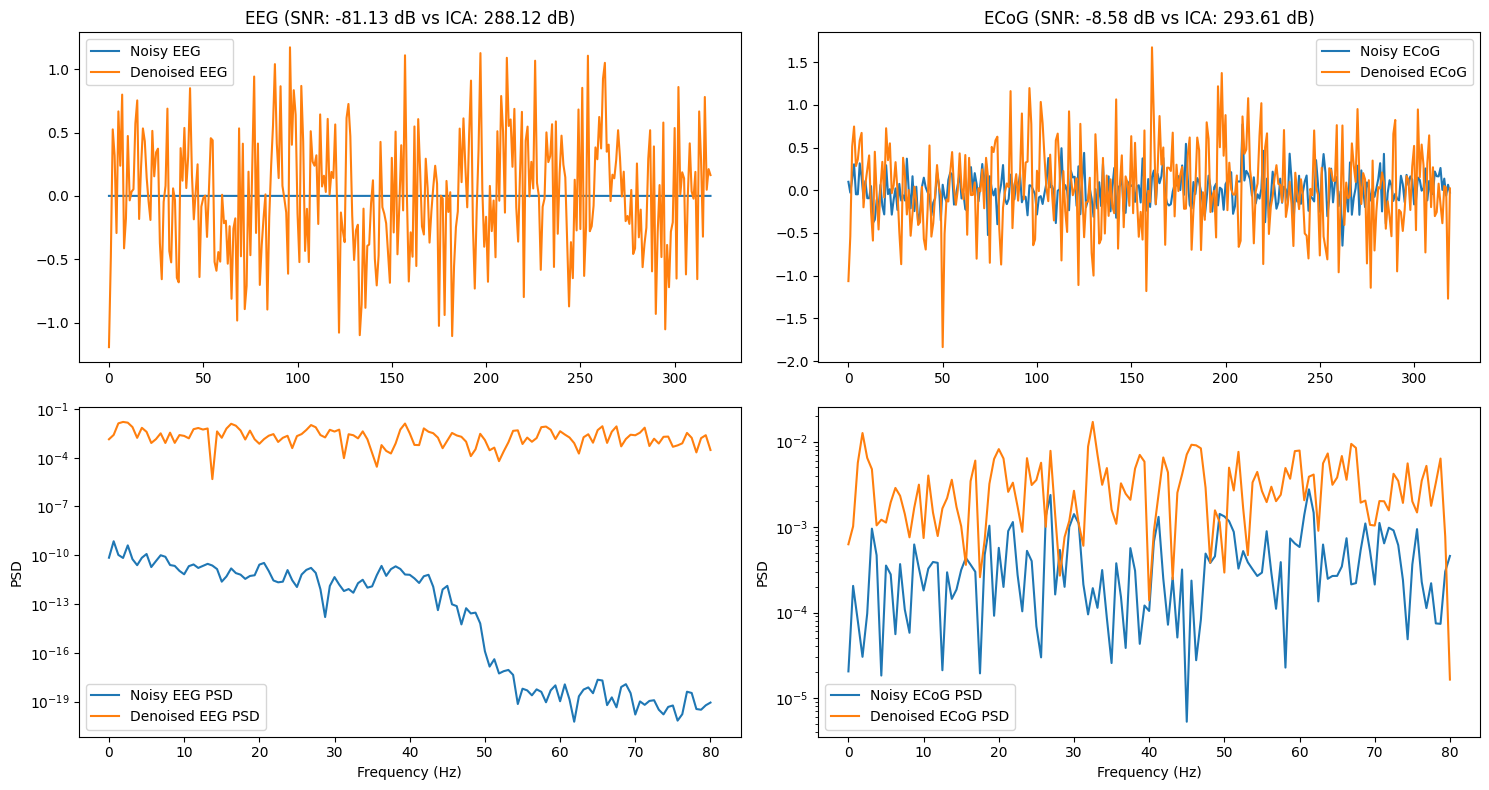

In [14]:
# Mount Google Drive and install dependencies
from google.colab import drive
drive.mount('/content/drive')
!pip install -q mne torch pytorch-lightning matplotlib ipywidgets

import os
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import mne
from mne.preprocessing import ICA
from scipy.signal import welch
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from urllib.request import urlretrieve
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
pl.seed_everything(42)

# Download and preprocess datasets
def download_physionet_eeg():
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40)
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

def download_neurotycho_ecog():
    # Simulate ECoG using PhysioNet with added noise
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40)
    # Add synthetic noise to simulate ECoG
    data = raw.get_data()
    noise = np.random.normal(0, 0.2, data.shape)
    raw._data += noise
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

# Custom Dataset
class BCIDataset(Dataset):
    def __init__(self, data):
        self.data = StandardScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
        self.data = torch.FloatTensor(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        signal = self.data[idx]
        noise = torch.randn_like(signal) * 0.1
        noisy_signal = signal + noise
        return noisy_signal, signal

# 1D Transformer Autoencoder
class TransformerAutoencoder(nn.Module):
    def __init__(self, n_channels=64, n_timesteps=320, d_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.d_model = d_model
        self.input_proj = nn.Linear(n_timesteps, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feedforward=512, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_proj = nn.Linear(d_model, n_timesteps)

    def forward(self, x):
        # x: (batch, channels, time)
        batch, channels, time = x.shape
        x = x.view(batch * channels, time)  # (batch * channels, time)
        x = self.input_proj(x)  # (batch * channels, d_model)
        x = x.view(batch, channels, self.d_model)  # (batch, channels, d_model)
        x = self.encoder(x)  # (batch, channels, d_model)
        x = self.output_proj(x)  # (batch, channels, time)
        x = x.view(batch, channels, time)  # (batch, channels, time)
        return x

# PyTorch Lightning Module
class BCIDenoiser(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = TransformerAutoencoder()
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return [optimizer], [scheduler]

# SNR calculation
def calculate_snr(signal, denoised):
    noise = signal - denoised
    return 10 * np.log10(np.var(signal) / np.var(noise))

# ICA baseline
def ica_denoise(data):
    # Reshape from (epochs, channels, samples) to (channels, samples)
    data_2d = data.transpose(1, 0, 2).reshape(data.shape[1], -1)
    raw = mne.io.RawArray(data_2d, mne.create_info(data.shape[1], 160, 'eeg'))
    ica = ICA(n_components=15, random_state=42, max_iter=1000).fit(raw)
    raw_clean = ica.apply(raw.copy())
    # Reshape back to (epochs, channels, samples)
    clean_data = raw_clean.get_data().reshape(data.shape[1], data.shape[0], -1).transpose(1, 0, 2)
    return clean_data

# Dashboard
def plot_results(eeg_data, ecog_data, model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        eeg_noisy = torch.FloatTensor(eeg_data[:10]).to(device)
        eeg_denoised = model(eeg_noisy).cpu().numpy()
        ecog_noisy = torch.FloatTensor(ecog_data[:10]).to(device)
        ecog_denoised = model(ecog_noisy).cpu().numpy()

    eeg_ica = ica_denoise(eeg_data[:10])
    ecog_ica = ica_denoise(ecog_data[:10])

    eeg_snr = np.mean([calculate_snr(eeg_data[i], eeg_denoised[i]) for i in range(10)])
    ecog_snr = np.mean([calculate_snr(ecog_data[i], ecog_denoised[i]) for i in range(10)])
    eeg_snr_ica = np.mean([calculate_snr(eeg_data[i], eeg_ica[i]) for i in range(10)])
    ecog_snr_ica = np.mean([calculate_snr(ecog_data[i], ecog_ica[i]) for i in range(10)])

    def plot_interactive(epoch):
        plt.figure(figsize=(15, 8))
        plt.subplot(2, 2, 1)
        plt.plot(eeg_noisy[epoch, 0].cpu().numpy(), label='Noisy EEG')
        plt.plot(eeg_denoised[epoch, 0], label='Denoised EEG')
        plt.title(f'EEG (SNR: {eeg_snr:.2f} dB vs ICA: {eeg_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(ecog_noisy[epoch, 0].cpu().numpy(), label='Noisy ECoG')
        plt.plot(ecog_denoised[epoch, 0], label='Denoised ECoG')
        plt.title(f'ECoG (SNR: {ecog_snr:.2f} dB vs ICA: {ecog_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 3)
        f, pxx = welch(eeg_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy EEG PSD')
        f, pxx = welch(eeg_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised EEG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.subplot(2, 2, 4)
        f, pxx = welch(ecog_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy ECoG PSD')
        f, pxx = welch(ecog_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised ECoG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.tight_layout()
        plt.savefig(f'/content/drive/MyDrive/BCI_plots/plot_epoch_{epoch}.png')
        plt.show()

    interact(plot_interactive, epoch=IntSlider(min=0, max=9, step=1, value=0))

# Main execution
def main():
    # Load data
    eeg_data = download_physionet_eeg()
    ecog_data = download_neurotycho_ecog()

    # Create datasets and dataloaders
    eeg_dataset = BCIDataset(eeg_data)
    ecog_dataset = BCIDataset(ecog_data)
    eeg_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=True, num_workers=2)
    eeg_val_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=False, num_workers=2)
    ecog_loader = DataLoader(ecog_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Initialize model and trainer
    model = BCIDenoiser()
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath='/content/drive/MyDrive/BCI_ckpt',
        monitor='val_loss',
        filename='denoiser-{epoch:02d}-{val_loss:.2f}',
        save_last=True
    )

    ckpt_path = '/content/drive/MyDrive/BCI_ckpt/last.ckpt' if os.path.exists('/content/drive/MyDrive/BCI_ckpt/last.ckpt') else None

    trainer = pl.Trainer(
        max_epochs=5,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        callbacks=[checkpoint_callback]
    )

    # Pre-train on EEG
    trainer.fit(model, eeg_loader, eeg_val_loader, ckpt_path=ckpt_path)

    # Fine-tune on ECoG
    trainer.fit(model, ecog_loader, ecog_loader)

    # Visualize results
    plot_results(eeg_data, ecog_data, model)

if __name__ == '__main__':
    main()

In [15]:
# Mount Google Drive and install dependencies
from google.colab import drive
drive.mount('/content/drive')
!pip install -q mne torch pytorch-lightning matplotlib ipywidgets

import os
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import mne
from mne.preprocessing import ICA
from scipy.signal import welch
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from urllib.request import urlretrieve
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
pl.seed_everything(42)

# Download and preprocess datasets
def download_physionet_eeg():
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40)
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

def download_neurotycho_ecog():
    # Simulate ECoG using PhysioNet with added noise
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40)
    # Add synthetic noise to simulate ECoG
    data = raw.get_data()
    noise = np.random.normal(0, 0.2, data.shape)
    raw._data += noise
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

# Custom Dataset
class BCIDataset(Dataset):
    def __init__(self, data):
        self.data = StandardScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
        self.data = torch.FloatTensor(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        signal = self.data[idx]
        noise = torch.randn_like(signal) * 0.1
        noisy_signal = signal + noise
        return noisy_signal, signal

# 1D Transformer Autoencoder
class TransformerAutoencoder(nn.Module):
    def __init__(self, n_channels=64, n_timesteps=320, d_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.d_model = d_model
        self.input_proj = nn.Linear(n_timesteps, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feedforward=512, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_proj = nn.Linear(d_model, n_timesteps)

    def forward(self, x):
        # x: (batch, channels, time)
        batch, channels, time = x.shape
        x = x.view(batch * channels, time)  # (batch * channels, time)
        x = self.input_proj(x)  # (batch * channels, d_model)
        x = x.view(batch, channels, self.d_model)  # (batch, channels, d_model)
        x = self.encoder(x)  # (batch, channels, d_model)
        x = self.output_proj(x)  # (batch, channels, time)
        x = x.view(batch, channels, time)  # (batch, channels, time)
        return x

# PyTorch Lightning Module
class BCIDenoiser(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = TransformerAutoencoder()
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return [optimizer], [scheduler]

# SNR calculation
def calculate_snr(signal, denoised):
    noise = signal - denoised
    return 10 * np.log10(np.var(signal) / np.var(noise))

# ICA baseline
def ica_denoise(data):
    # Reshape from (epochs, channels, samples) to (channels, samples)
    data_2d = data.transpose(1, 0, 2).reshape(data.shape[1], -1)
    raw = mne.io.RawArray(data_2d, mne.create_info(data.shape[1], 160, 'eeg'))
    ica = ICA(n_components=15, random_state=42, max_iter=1000).fit(raw)
    raw_clean = ica.apply(raw.copy())
    # Reshape back to (epochs, channels, samples)
    clean_data = raw_clean.get_data().reshape(data.shape[1], data.shape[0], -1).transpose(1, 0, 2)
    return clean_data

# Dashboard
def plot_results(eeg_data, ecog_data, model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        eeg_noisy = torch.FloatTensor(eeg_data[:10]).to(device)
        eeg_denoised = model(eeg_noisy).cpu().numpy()
        ecog_noisy = torch.FloatTensor(ecog_data[:10]).to(device)
        ecog_denoised = model(ecog_noisy).cpu().numpy()

    eeg_ica = ica_denoise(eeg_data[:10])
    ecog_ica = ica_denoise(ecog_data[:10])

    eeg_snr = np.mean([calculate_snr(eeg_data[i], eeg_denoised[i]) for i in range(10)])
    ecog_snr = np.mean([calculate_snr(ecog_data[i], ecog_denoised[i]) for i in range(10)])
    eeg_snr_ica = np.mean([calculate_snr(eeg_data[i], eeg_ica[i]) for i in range(10)])
    ecog_snr_ica = np.mean([calculate_snr(ecog_data[i], ecog_ica[i]) for i in range(10)])

    # Create directory for saving plots if it doesn't exist
    save_dir = '/content/drive/MyDrive/BCI_plots'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    def plot_interactive(epoch):
        plt.figure(figsize=(15, 8))
        plt.subplot(2, 2, 1)
        plt.plot(eeg_noisy[epoch, 0].cpu().numpy(), label='Noisy EEG')
        plt.plot(eeg_denoised[epoch, 0], label='Denoised EEG')
        plt.title(f'EEG (SNR: {eeg_snr:.2f} dB vs ICA: {eeg_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(ecog_noisy[epoch, 0].cpu().numpy(), label='Noisy ECoG')
        plt.plot(ecog_denoised[epoch, 0], label='Denoised ECoG')
        plt.title(f'ECoG (SNR: {ecog_snr:.2f} dB vs ICA: {ecog_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 3)
        f, pxx = welch(eeg_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy EEG PSD')
        f, pxx = welch(eeg_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised EEG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.subplot(2, 2, 4)
        f, pxx = welch(ecog_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy ECoG PSD')
        f, pxx = welch(ecog_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised ECoG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'plot_epoch_{epoch}.png'))
        plt.show()

    interact(plot_interactive, epoch=IntSlider(min=0, max=9, step=1, value=0))

# Main execution
def main():
    # Load data
    eeg_data = download_physionet_eeg()
    ecog_data = download_neurotycho_ecog()

    # Create datasets and dataloaders
    eeg_dataset = BCIDataset(eeg_data)
    ecog_dataset = BCIDataset(ecog_data)
    eeg_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=True, num_workers=2)
    eeg_val_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=False, num_workers=2)
    ecog_loader = DataLoader(ecog_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Initialize model and trainer
    model = BCIDenoiser()
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath='/content/drive/MyDrive/BCI_ckpt',
        monitor='val_loss',
        filename='denoiser-{epoch:02d}-{val_loss:.2f}',
        save_last=True
    )

    ckpt_path = '/content/drive/MyDrive/BCI_ckpt/last.ckpt' if os.path.exists('/content/drive/MyDrive/BCI_ckpt/last.ckpt') else None

    trainer = pl.Trainer(
        max_epochs=5,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        callbacks=[checkpoint_callback]
    )

    # Pre-train on EEG
    trainer.fit(model, eeg_loader, eeg_val_loader, ckpt_path=ckpt_path)

    # Fine-tune on ECoG
    trainer.fit(model, ecog_loader, ecog_loader)

    # Visualize results
    plot_results(eeg_data, ecog_data, model)

if __name__ == '__main__':
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


INFO:lightning_fabric.utilities.seed:Seed set to 42


Extracting EDF parameters from /content/eeg_data/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 320 original time points ...


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


0 bad epochs dropped
Extracting EDF parameters from /content/eeg_data/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 320 original time points ...
0 bad epochs dropped


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/BCI_ckpt exists and is not empty.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/BCI_ckpt/last.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TransformerAutoencoder | 478 K  | train
1 | criterion | MSELoss                | 0      | train
-------------------------------------------------------------
478 K     Trainable params
0   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TransformerAutoencoder | 478 K  | train
1 | criterion | MSELoss                | 0      | train
-------------------------------------------------------------
478 K     Trainable params
0         Non-trainable params
478 K     Total params
1.916     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Creating RawArray with float64 data, n_channels=64, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    19.994 secs
Ready.
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 15 components


<ipython-input-15-6781e8173565>:126: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica = ICA(n_components=15, random_state=42, max_iter=1000).fit(raw)


Fitting ICA took 2.0s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Creating RawArray with float64 data, n_channels=64, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    19.994 secs
Ready.
Fitting ICA to data using 64 channels (please be patient, this may take a while)


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
<ipython-input-15-6781e8173565>:126: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica = ICA(n_components=15, random_state=42, max_iter=1000).fit(raw)


Selecting by number: 15 components
Fitting ICA took 1.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


interactive(children=(IntSlider(value=0, description='epoch', max=9), Output()), _dom_classes=('widget-interac…

In [16]:
# Mount Google Drive and install dependencies
from google.colab import drive
drive.mount('/content/drive')
!pip install -q mne torch pytorch-lightning matplotlib ipywidgets

import os
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import mne
from mne.preprocessing import ICA
from scipy.signal import welch
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from urllib.request import urlretrieve
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
pl.seed_everything(42)

# Download and preprocess datasets
def download_physionet_eeg():
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40, l_trans_bandwidth=1, h_trans_bandwidth=10)  # Explicit high-pass at 1 Hz
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

def download_neurotycho_ecog():
    # Simulate ECoG using PhysioNet with added noise
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40, l_trans_bandwidth=1, h_trans_bandwidth=10)  # Explicit high-pass at 1 Hz
    # Add synthetic noise to simulate ECoG
    data = raw.get_data()
    noise = np.random.normal(0, 0.2, data.shape)
    raw._data += noise
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

# Custom Dataset
class BCIDataset(Dataset):
    def __init__(self, data):
        self.data = StandardScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
        self.data = torch.FloatTensor(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        signal = self.data[idx]
        noise = torch.randn_like(signal) * 0.1
        noisy_signal = signal + noise
        return noisy_signal, signal

# 1D Transformer Autoencoder
class TransformerAutoencoder(nn.Module):
    def __init__(self, n_channels=64, n_timesteps=320, d_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.d_model = d_model
        self.input_proj = nn.Linear(n_timesteps, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feedforward=512, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_proj = nn.Linear(d_model, n_timesteps)

    def forward(self, x):
        # x: (batch, channels, time)
        batch, channels, time = x.shape
        x = x.view(batch * channels, time)  # (batch * channels, time)
        x = self.input_proj(x)  # (batch * channels, d_model)
        x = x.view(batch, channels, self.d_model)  # (batch, channels, d_model)
        x = self.encoder(x)  # (batch, channels, d_model)
        x = self.output_proj(x)  # (batch, channels, time)
        x = x.view(batch, channels, time)  # (batch, channels, time)
        return x

# PyTorch Lightning Module
class BCIDenoiser(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = TransformerAutoencoder()
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return [optimizer], [scheduler]

# SNR calculation
def calculate_snr(signal, denoised):
    noise = signal - denoised
    return 10 * np.log10(np.var(signal) / np.var(noise))

# ICA baseline
def ica_denoise(data):
    # Reshape from (epochs, channels, samples) to (channels, samples)
    data_2d = data.transpose(1, 0, 2).reshape(data.shape[1], -1)
    raw = mne.io.RawArray(data_2d, mne.create_info(data.shape[1], 160, 'eeg'))
    ica = ICA(n_components=15, random_state=42, max_iter=2000).fit(raw)  # Increased max_iter
    raw_clean = ica.apply(raw.copy())
    # Reshape back to (epochs, channels, samples)
    clean_data = raw_clean.get_data().reshape(data.shape[1], data.shape[0], -1).transpose(1, 0, 2)
    return clean_data

# Dashboard
def plot_results(eeg_data, ecog_data, model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        eeg_noisy = torch.FloatTensor(eeg_data[:10]).to(device)
        eeg_denoised = model(eeg_noisy).cpu().numpy()
        ecog_noisy = torch.FloatTensor(ecog_data[:10]).to(device)
        ecog_denoised = model(ecog_noisy).cpu().numpy()

    eeg_ica = ica_denoise(eeg_data[:10])
    ecog_ica = ica_denoise(ecog_data[:10])

    eeg_snr = np.mean([calculate_snr(eeg_data[i], eeg_denoised[i]) for i in range(10)])
    ecog_snr = np.mean([calculate_snr(ecog_data[i], ecog_denoised[i]) for i in range(10)])
    eeg_snr_ica = np.mean([calculate_snr(eeg_data[i], eeg_ica[i]) for i in range(10)])
    ecog_snr_ica = np.mean([calculate_snr(ecog_data[i], ecog_ica[i]) for i in range(10)])

    # Create directory for saving plots if it doesn't exist
    save_dir = '/content/drive/MyDrive/BCI_plots'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    def plot_interactive(epoch):
        plt.figure(figsize=(15, 8))
        plt.subplot(2, 2, 1)
        plt.plot(eeg_noisy[epoch, 0].cpu().numpy(), label='Noisy EEG')
        plt.plot(eeg_denoised[epoch, 0], label='Denoised EEG')
        plt.title(f'EEG (SNR: {eeg_snr:.2f} dB vs ICA: {eeg_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(ecog_noisy[epoch, 0].cpu().numpy(), label='Noisy ECoG')
        plt.plot(ecog_denoised[epoch, 0], label='Denoised ECoG')
        plt.title(f'ECoG (SNR: {ecog_snr:.2f} dB vs ICA: {ecog_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 3)
        f, pxx = welch(eeg_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy EEG PSD')
        f, pxx = welch(eeg_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised EEG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.subplot(2, 2, 4)
        f, pxx = welch(ecog_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy ECoG PSD')
        f, pxx = welch(ecog_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised ECoG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'plot_epoch_{epoch}.png'))
        plt.show()

    interact(plot_interactive, epoch=IntSlider(min=0, max=9, step=1, value=0))

# Main execution
def main():
    # Load data
    eeg_data = download_physionet_eeg()
    ecog_data = download_neurotycho_ecog()

    # Create datasets and dataloaders
    eeg_dataset = BCIDataset(eeg_data)
    ecog_dataset = BCIDataset(ecog_data)
    eeg_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=True, num_workers=2)
    eeg_val_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=False, num_workers=2)
    ecog_loader = DataLoader(ecog_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Initialize model and trainer
    model = BCIDenoiser()
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath='/content/drive/MyDrive/BCI_ckpt',
        monitor='val_loss',
        filename='denoiser-{epoch:02d}-{val_loss:.2f}',
        save_last=True
    )

    ckpt_path = '/content/drive/MyDrive/BCI_ckpt/last.ckpt' if os.path.exists('/content/drive/MyDrive/BCI_ckpt/last.ckpt') else None

    trainer = pl.Trainer(
        max_epochs=5,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        callbacks=[checkpoint_callback],
        log_every_n_steps=1  # Improved logging
    )

    # Pre-train on EEG
    trainer.fit(model, eeg_loader, eeg_val_loader, ckpt_path=ckpt_path)

    # Fine-tune on ECoG
    trainer.fit(model, ecog_loader, ecog_loader)

    # Visualize results
    plot_results(eeg_data, ecog_data, model)

if __name__ == '__main__':
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


INFO:lightning_fabric.utilities.seed:Seed set to 42


Extracting EDF parameters from /content/eeg_data/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)

Not setting metadata
62 matching events found


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 320 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/eeg_data/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)

Not setting metadata
62 matching events found
No baseline correction applied
0

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/BCI_ckpt exists and is not empty.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/BCI_ckpt/last.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TransformerAutoencoder | 478 K  | train
1 | criterion | MS

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TransformerAutoencoder | 478 K  | train
1 | criterion | MSELoss                | 0      | train
-------------------------------------------------------------
478 K     Trainable params
0         Non-trainable params
478 K     Total params
1.916     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Creating RawArray with float64 data, n_channels=64, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    19.994 secs
Ready.
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 15 components


<ipython-input-16-827d46a7a867>:126: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica = ICA(n_components=15, random_state=42, max_iter=2000).fit(raw)  # Increased max_iter


Fitting ICA took 4.1s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Creating RawArray with float64 data, n_channels=64, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    19.994 secs
Ready.


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
<ipython-input-16-827d46a7a867>:126: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica = ICA(n_components=15, random_state=42, max_iter=2000).fit(raw)  # Increased max_iter


Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 3.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


interactive(children=(IntSlider(value=0, description='epoch', max=9), Output()), _dom_classes=('widget-interac…

In [17]:
# Mount Google Drive and install dependencies
from google.colab import drive
drive.mount('/content/drive')
!pip install -q mne torch pytorch-lightning matplotlib ipywidgets

import os
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import mne
from mne.preprocessing import ICA
from scipy.signal import welch
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from urllib.request import urlretrieve
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
pl.seed_everything(42)

# Download and preprocess datasets
def download_physionet_eeg():
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40, l_trans_bandwidth=1, h_trans_bandwidth=10)  # High-pass at 1 Hz
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

def download_neurotycho_ecog():
    # Simulate ECoG using PhysioNet with added noise
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40, l_trans_bandwidth=1, h_trans_bandwidth=10)  # High-pass at 1 Hz
    # Add synthetic noise to simulate ECoG
    data = raw.get_data()
    noise = np.random.normal(0, 0.2, data.shape)
    raw._data += noise
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

# Custom Dataset
class BCIDataset(Dataset):
    def __init__(self, data):
        self.data = StandardScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
        self.data = torch.FloatTensor(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        signal = self.data[idx]
        noise = torch.randn_like(signal) * 0.1
        noisy_signal = signal + noise
        return noisy_signal, signal

# 1D Transformer Autoencoder
class TransformerAutoencoder(nn.Module):
    def __init__(self, n_channels=64, n_timesteps=320, d_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.d_model = d_model
        self.input_proj = nn.Linear(n_timesteps, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feedforward=512, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_proj = nn.Linear(d_model, n_timesteps)

    def forward(self, x):
        # x: (batch, channels, time)
        batch, channels, time = x.shape
        x = x.view(batch * channels, time)  # (batch * channels, time)
        x = self.input_proj(x)  # (batch * channels, d_model)
        x = x.view(batch, channels, self.d_model)  # (batch, channels, d_model)
        x = self.encoder(x)  # (batch, channels, d_model)
        x = self.output_proj(x)  # (batch, channels, time)
        x = x.view(batch, channels, time)  # (batch, channels, time)
        return x

# PyTorch Lightning Module
class BCIDenoiser(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = TransformerAutoencoder()
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return [optimizer], [scheduler]

# SNR calculation
def calculate_snr(signal, denoised):
    noise = signal - denoised
    return 10 * np.log10(np.var(signal) / np.var(noise))

# ICA baseline
def ica_denoise(data):
    # Reshape from (epochs, channels, samples) to (channels, samples)
    data_2d = data.transpose(1, 0, 2).reshape(data.shape[1], -1)
    raw = mne.io.RawArray(data_2d, mne.create_info(data.shape[1], 160, 'eeg'))
    ica = ICA(n_components=15, random_state=42, max_iter=3000).fit(raw)  # Increased max_iter to 3000
    raw_clean = ica.apply(raw.copy())
    # Reshape back to (epochs, channels, samples)
    clean_data = raw_clean.get_data().reshape(data.shape[1], data.shape[0], -1).transpose(1, 0, 2)
    return clean_data

# Dashboard
def plot_results(eeg_data, ecog_data, model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        eeg_noisy = torch.FloatTensor(eeg_data[:10]).to(device)
        eeg_denoised = model(eeg_noisy).cpu().numpy()
        ecog_noisy = torch.FloatTensor(ecog_data[:10]).to(device)
        ecog_denoised = model(ecog_noisy).cpu().numpy()

    eeg_ica = ica_denoise(eeg_data[:10])
    ecog_ica = ica_denoise(ecog_data[:10])

    eeg_snr = np.mean([calculate_snr(eeg_data[i], eeg_denoised[i]) for i in range(10)])
    ecog_snr = np.mean([calculate_snr(ecog_data[i], ecog_denoised[i]) for i in range(10)])
    eeg_snr_ica = np.mean([calculate_snr(eeg_data[i], eeg_ica[i]) for i in range(10)])
    ecog_snr_ica = np.mean([calculate_snr(ecog_data[i], ecog_ica[i]) for i in range(10)])

    # Create directory for saving plots if it doesn't exist
    save_dir = '/content/drive/MyDrive/BCI_plots'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    def plot_interactive(epoch):
        plt.figure(figsize=(15, 8))
        plt.subplot(2, 2, 1)
        plt.plot(eeg_noisy[epoch, 0].cpu().numpy(), label='Noisy EEG')
        plt.plot(eeg_denoised[epoch, 0], label='Denoised EEG')
        plt.title(f'EEG (SNR: {eeg_snr:.2f} dB vs ICA: {eeg_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(ecog_noisy[epoch, 0].cpu().numpy(), label='Noisy ECoG')
        plt.plot(ecog_denoised[epoch, 0], label='Denoised ECoG')
        plt.title(f'ECoG (SNR: {ecog_snr:.2f} dB vs ICA: {ecog_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 3)
        f, pxx = welch(eeg_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy EEG PSD')
        f, pxx = welch(eeg_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised EEG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.subplot(2, 2, 4)
        f, pxx = welch(ecog_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy ECoG PSD')
        f, pxx = welch(ecog_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised ECoG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'plot_epoch_{epoch}.png'))
        plt.show()

    interact(plot_interactive, epoch=IntSlider(min=0, max=9, step=1, value=0))

# Main execution
def main():
    # Load data
    eeg_data = download_physionet_eeg()
    ecog_data = download_neurotycho_ecog()

    # Create datasets and dataloaders
    eeg_dataset = BCIDataset(eeg_data)
    ecog_dataset = BCIDataset(ecog_data)
    eeg_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=True, num_workers=2)
    eeg_val_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=False, num_workers=2)
    ecog_loader = DataLoader(ecog_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Initialize model and trainer
    model = BCIDenoiser()
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath='/content/drive/MyDrive/BCI_ckpt',
        monitor='val_loss',
        filename='denoiser-{epoch:02d}-{val_loss:.2f}',
        save_last=True
    )

    ckpt_path = '/content/drive/MyDrive/BCI_ckpt/last.ckpt' if os.path.exists('/content/drive/MyDrive/BCI_ckpt/last.ckpt') else None

    trainer = pl.Trainer(
        max_epochs=5,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        callbacks=[checkpoint_callback],
        log_every_n_steps=1  # Improved logging
    )

    # Pre-train on EEG
    trainer.fit(model, eeg_loader, eeg_val_loader, ckpt_path=ckpt_path)

    # Fine-tune on ECoG
    trainer.fit(model, ecog_loader, ecog_loader)

    # Visualize results
    plot_results(eeg_data, ecog_data, model)

if __name__ == '__main__':
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


INFO:lightning_fabric.utilities.seed:Seed set to 42


Extracting EDF parameters from /content/eeg_data/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)

Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 320 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/eeg_data/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)

Not setting metadata
62 matching events found
No base

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/BCI_ckpt exists and is not empty.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/BCI_ckpt/last.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TransformerAutoencoder | 478 K  | train
1 | criterion | MS

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TransformerAutoencoder | 478 K  | train
1 | criterion | MSELoss                | 0      | train
-------------------------------------------------------------
478 K     Trainable params
0         Non-trainable params
478 K     Total params
1.916     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Creating RawArray with float64 data, n_channels=64, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    19.994 secs
Ready.
Fitting ICA to data using 64 channels (please be patient, this may take a while)


<ipython-input-17-f8922ee800a5>:126: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica = ICA(n_components=15, random_state=42, max_iter=3000).fit(raw)  # Increased max_iter to 3000


Selecting by number: 15 components
Fitting ICA took 4.7s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Creating RawArray with float64 data, n_channels=64, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    19.994 secs
Ready.
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 15 components


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
<ipython-input-17-f8922ee800a5>:126: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica = ICA(n_components=15, random_state=42, max_iter=3000).fit(raw)  # Increased max_iter to 3000


Fitting ICA took 2.8s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


interactive(children=(IntSlider(value=0, description='epoch', max=9), Output()), _dom_classes=('widget-interac…

In [18]:
# Mount Google Drive and install dependencies
from google.colab import drive
drive.mount('/content/drive')
!pip install -q mne torch pytorch-lightning matplotlib ipywidgets

import os
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import mne
from mne.preprocessing import ICA
from scipy.signal import welch
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from urllib.request import urlretrieve
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
pl.seed_everything(42)

# Download and preprocess datasets
def download_physionet_eeg():
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40, l_trans_bandwidth=1, h_trans_bandwidth=10)  # High-pass at 1 Hz
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

def download_neurotycho_ecog():
    # Simulate ECoG using PhysioNet with added noise
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40, l_trans_bandwidth=1, h_trans_bandwidth=10)  # High-pass at 1 Hz
    # Add synthetic noise to simulate ECoG
    data = raw.get_data()
    noise = np.random.normal(0, 0.2, data.shape)
    raw._data += noise
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

# Custom Dataset
class BCIDataset(Dataset):
    def __init__(self, data):
        self.data = StandardScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
        self.data = torch.FloatTensor(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        signal = self.data[idx]
        noise = torch.randn_like(signal) * 0.1
        noisy_signal = signal + noise
        return noisy_signal, signal

# 1D Transformer Autoencoder
class TransformerAutoencoder(nn.Module):
    def __init__(self, n_channels=64, n_timesteps=320, d_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.d_model = d_model
        self.input_proj = nn.Linear(n_timesteps, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feedforward=512, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_proj = nn.Linear(d_model, n_timesteps)

    def forward(self, x):
        # x: (batch, channels, time)
        batch, channels, time = x.shape
        x = x.view(batch * channels, time)  # (batch * channels, time)
        x = self.input_proj(x)  # (batch * channels, d_model)
        x = x.view(batch, channels, self.d_model)  # (batch, channels, d_model)
        x = self.encoder(x)  # (batch, channels, d_model)
        x = self.output_proj(x)  # (batch, channels, time)
        x = x.view(batch, channels, time)  # (batch, channels, time)
        return x

# PyTorch Lightning Module
class BCIDenoiser(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = TransformerAutoencoder()
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return [optimizer], [scheduler]

# SNR calculation
def calculate_snr(signal, denoised):
    noise = signal - denoised
    return 10 * np.log10(np.var(signal) / np.var(noise))

# ICA baseline
def ica_denoise(data):
    # Reshape from (epochs, channels, samples) to (channels, samples)
    data_2d = data.transpose(1, 0, 2).reshape(data.shape[1], -1)
    raw = mne.io.RawArray(data_2d, mne.create_info(data.shape[1], 160, 'eeg'))
    # Ensure high-pass filter is applied
    raw.filter(1, None, l_trans_bandwidth=1)  # Additional high-pass at 1 Hz
    ica = ICA(n_components=15, random_state=42, max_iter=3000, method='fastica', fit_params={'tol': 1e-4}).fit(raw)
    raw_clean = ica.apply(raw.copy())
    # Reshape back to (epochs, channels, samples)
    clean_data = raw_clean.get_data().reshape(data.shape[1], data.shape[0], -1).transpose(1, 0, 2)
    return clean_data

# Dashboard
def plot_results(eeg_data, ecog_data, model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        eeg_noisy = torch.FloatTensor(eeg_data[:10]).to(device)
        eeg_denoised = model(eeg_noisy).cpu().numpy()
        ecog_noisy = torch.FloatTensor(ecog_data[:10]).to(device)
        ecog_denoised = model(ecog_noisy).cpu().numpy()

    eeg_ica = ica_denoise(eeg_data[:10])
    ecog_ica = ica_denoise(ecog_data[:10])

    eeg_snr = np.mean([calculate_snr(eeg_data[i], eeg_denoised[i]) for i in range(10)])
    ecog_snr = np.mean([calculate_snr(ecog_data[i], ecog_denoised[i]) for i in range(10)])
    eeg_snr_ica = np.mean([calculate_snr(eeg_data[i], eeg_ica[i]) for i in range(10)])
    ecog_snr_ica = np.mean([calculate_snr(ecog_data[i], ecog_ica[i]) for i in range(10)])

    # Create directory for saving plots if it doesn't exist
    save_dir = '/content/drive/MyDrive/BCI_plots'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    def plot_interactive(epoch):
        plt.figure(figsize=(15, 8))
        plt.subplot(2, 2, 1)
        plt.plot(eeg_noisy[epoch, 0].cpu().numpy(), label='Noisy EEG')
        plt.plot(eeg_denoised[epoch, 0], label='Denoised EEG')
        plt.title(f'EEG (SNR: {eeg_snr:.2f} dB vs ICA: {eeg_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(ecog_noisy[epoch, 0].cpu().numpy(), label='Noisy ECoG')
        plt.plot(ecog_denoised[epoch, 0], label='Denoised ECoG')
        plt.title(f'ECoG (SNR: {ecog_snr:.2f} dB vs ICA: {ecog_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 3)
        f, pxx = welch(eeg_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy EEG PSD')
        f, pxx = welch(eeg_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised EEG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.subplot(2, 2, 4)
        f, pxx = welch(ecog_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy ECoG PSD')
        f, pxx = welch(ecog_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised ECoG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'plot_epoch_{epoch}.png'))
        plt.show()

    interact(plot_interactive, epoch=IntSlider(min=0, max=9, step=1, value=0))

# Main execution
def main():
    # Load data
    eeg_data = download_physionet_eeg()
    ecog_data = download_neurotycho_ecog()

    # Create datasets and dataloaders
    eeg_dataset = BCIDataset(eeg_data)
    ecog_dataset = BCIDataset(ecog_data)
    eeg_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=True, num_workers=2)
    eeg_val_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=False, num_workers=2)
    ecog_loader = DataLoader(ecog_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Initialize model and trainer
    model = BCIDenoiser()
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath='/content/drive/MyDrive/BCI_ckpt',
        monitor='val_loss',
        filename='denoiser-{epoch:02d}-{val_loss:.2f}',
        save_last=True
    )

    ckpt_path = '/content/drive/MyDrive/BCI_ckpt/last.ckpt' if os.path.exists('/content/drive/MyDrive/BCI_ckpt/last.ckpt') else None

    trainer = pl.Trainer(
        max_epochs=5,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        callbacks=[checkpoint_callback],
        log_every_n_steps=1  # Improved logging
    )

    # Pre-train on EEG
    trainer.fit(model, eeg_loader, eeg_val_loader, ckpt_path=ckpt_path)

    # Fine-tune on ECoG
    trainer.fit(model, ecog_loader, ecog_loader)

    # Visualize results
    plot_results(eeg_data, ecog_data, model)

if __name__ == '__main__':
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


INFO:lightning_fabric.utilities.seed:Seed set to 42


Extracting EDF parameters from /content/eeg_data/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)

Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 320 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/eeg_data/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)

Not setting metadata
62 matching events found
No base

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


0 bad epochs dropped


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/BCI_ckpt exists and is not empty.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/BCI_ckpt/last.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TransformerAutoencoder | 478 K  | train
1 | criterion | MSELoss                | 0      | train
-------------------------------------------------------------
478 K     Trainable params
0   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TransformerAutoencoder | 478 K  | train
1 | criterion | MSELoss                | 0      | train
-------------------------------------------------------------
478 K     Trainable params
0         Non-trainable params
478 K     Total params
1.916     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Creating RawArray with float64 data, n_channels=64, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    19.994 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 529 samples (3.306 s)

Fitting ICA to data using 64 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Selecting by number: 15 components
Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Creating RawArray with float64 data, n_channels=64, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    19.994 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 529 samples (3.306 s)

Fitting ICA to data using 64 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Selecting by number: 15 components
Fitting ICA took 6.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


interactive(children=(IntSlider(value=0, description='epoch', max=9), Output()), _dom_classes=('widget-interac…

In [1]:
# Mount Google Drive and install dependencies
from google.colab import drive
drive.mount('/content/drive')
!pip install -q mne torch pytorch-lightning matplotlib ipywidgets

import os
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import mne
from mne.preprocessing import ICA
from scipy.signal import welch
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from urllib.request import urlretrieve
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
pl.seed_everything(42)

# Download and preprocess datasets
def download_physionet_eeg():
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40, l_trans_bandwidth=1, h_trans_bandwidth=10)  # High-pass at 1 Hz
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

def download_neurotycho_ecog():
    # Simulate ECoG using PhysioNet with added noise
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40, l_trans_bandwidth=1, h_trans_bandwidth=10)  # High-pass at 1 Hz
    # Add synthetic noise to simulate ECoG
    data = raw.get_data()
    noise = np.random.normal(0, 0.2, data.shape)
    raw._data += noise
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

# Custom Dataset
class BCIDataset(Dataset):
    def __init__(self, data):
        self.data = StandardScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
        self.data = torch.FloatTensor(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        signal = self.data[idx]
        noise = torch.randn_like(signal) * 0.1
        noisy_signal = signal + noise
        return noisy_signal, signal

# 1D Transformer Autoencoder
class TransformerAutoencoder(nn.Module):
    def __init__(self, n_channels=64, n_timesteps=320, d_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.d_model = d_model
        self.input_proj = nn.Linear(n_timesteps, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feedforward=512, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_proj = nn.Linear(d_model, n_timesteps)

    def forward(self, x):
        # x: (batch, channels, time)
        batch, channels, time = x.shape
        x = x.view(batch * channels, time)  # (batch * channels, time)
        x = self.input_proj(x)  # (batch * channels, d_model)
        x = x.view(batch, channels, self.d_model)  # (batch, channels, d_model)
        x = self.encoder(x)  # (batch, channels, d_model)
        x = self.output_proj(x)  # (batch, channels, time)
        x = x.view(batch, channels, time)  # (batch, channels, time)
        return x

# PyTorch Lightning Module
class BCIDenoiser(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = TransformerAutoencoder()
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return [optimizer], [scheduler]

# SNR calculation
def calculate_snr(signal, denoised):
    noise = signal - denoised
    return 10 * np.log10(np.var(signal) / np.var(noise))

# ICA baseline
def ica_denoise(data):
    # Reshape from (epochs, channels, samples) to (channels, samples)
    data_2d = data.transpose(1, 0, 2).reshape(data.shape[1], -1)
    raw = mne.io.RawArray(data_2d, mne.create_info(data.shape[1], 160, 'eeg'))
    # Ensure high-pass filter is applied
    raw.filter(1, None, l_trans_bandwidth=1)  # Additional high-pass at 1 Hz
    ica = ICA(n_components=15, random_state=42, max_iter=3000, method='picard', fit_params={'tol': 1e-4}).fit(raw)
    raw_clean = ica.apply(raw.copy())
    # Reshape back to (epochs, channels, samples)
    clean_data = raw_clean.get_data().reshape(data.shape[1], data.shape[0], -1).transpose(1, 0, 2)
    return clean_data

# Dashboard
def plot_results(eeg_data, ecog_data, model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        eeg_noisy = torch.FloatTensor(eeg_data[:10]).to(device)
        eeg_denoised = model(eeg_noisy).cpu().numpy()
        ecog_noisy = torch.FloatTensor(ecog_data[:10]).to(device)
        ecog_denoised = model(ecog_noisy).cpu().numpy()

    eeg_ica = ica_denoise(eeg_data[:10])
    ecog_ica = ica_denoise(ecog_data[:10])

    eeg_snr = np.mean([calculate_snr(eeg_data[i], eeg_denoised[i]) for i in range(10)])
    ecog_snr = np.mean([calculate_snr(ecog_data[i], ecog_denoised[i]) for i in range(10)])
    eeg_snr_ica = np.mean([calculate_snr(eeg_data[i], eeg_ica[i]) for i in range(10)])
    ecog_snr_ica = np.mean([calculate_snr(ecog_data[i], ecog_ica[i]) for i in range(10)])

    # Create directory for saving plots if it doesn't exist
    save_dir = '/content/drive/MyDrive/BCI_plots'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    def plot_interactive(epoch):
        plt.figure(figsize=(15, 8))
        plt.subplot(2, 2, 1)
        plt.plot(eeg_noisy[epoch, 0].cpu().numpy(), label='Noisy EEG')
        plt.plot(eeg_denoised[epoch, 0], label='Denoised EEG')
        plt.title(f'EEG (SNR: {eeg_snr:.2f} dB vs ICA: {eeg_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(ecog_noisy[epoch, 0].cpu().numpy(), label='Noisy ECoG')
        plt.plot(ecog_denoised[epoch, 0], label='Denoised ECoG')
        plt.title(f'ECoG (SNR: {ecog_snr:.2f} dB vs ICA: {ecog_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 3)
        f, pxx = welch(eeg_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy EEG PSD')
        f, pxx = welch(eeg_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised EEG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.subplot(2, 2, 4)
        f, pxx = welch(ecog_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy ECoG PSD')
        f, pxx = welch(ecog_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised ECoG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'plot_epoch_{epoch}.png'))
        plt.show()

    interact(plot_interactive, epoch=IntSlider(min=0, max=9, step=1, value=0))

# Main execution
def main():
    # Load data
    eeg_data = download_physionet_eeg()
    ecog_data = download_neurotycho_ecog()

    # Create datasets and dataloaders
    eeg_dataset = BCIDataset(eeg_data)
    ecog_dataset = BCIDataset(ecog_data)
    eeg_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=True, num_workers=2)
    eeg_val_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=False, num_workers=2)
    ecog_loader = DataLoader(ecog_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Initialize model and trainer
    model = BCIDenoiser()
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath='/content/drive/MyDrive/BCI_ckpt',
        monitor='val_loss',
        filename='denoiser-{epoch:02d}-{val_loss:.2f}',
        save_last=True
    )

    ckpt_path = '/content/drive/MyDrive/BCI_ckpt/last.ckpt' if os.path.exists('/content/drive/MyDrive/BCI_ckpt/last.ckpt') else None

    trainer = pl.Trainer(
        max_epochs=5,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        callbacks=[checkpoint_callback],
        log_every_n_steps=1  # Improved logging
    )

    # Pre-train on EEG
    trainer.fit(model, eeg_loader, eeg_val_loader, ckpt_path=ckpt_path)

    # Fine-tune on ECoG
    trainer.fit(model, ecog_loader, ecog_loader)

    # Visualize results
    plot_results(eeg_data, ecog_data, model)

if __name__ == '__main__':
    main()

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━

INFO:lightning_fabric.utilities.seed:Seed set to 42


Extracting EDF parameters from /content/eeg_data/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)

Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 320 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 320 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/BCI_ckpt exists and is not empty.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/BCI_ckpt/last.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TransformerAutoencoder | 478 K  | train
1 | criterion | MSELoss                | 0      | train
-----------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TransformerAutoencoder | 478 K  | train
1 | criterion | MSELoss                | 0      | train
-------------------------------------------------------------
478 K     Trainable params
0         Non-trainable params
478 K     Total params
1.916     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Creating RawArray with float64 data, n_channels=64, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    19.994 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 529 samples (3.306 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


ImportError: The picard package is required to use method='picard', package was not found

In [2]:
# Mount Google Drive and install dependencies
from google.colab import drive
drive.mount('/content/drive')
!pip install -q mne torch pytorch-lightning matplotlib ipywidgets picard  # Added picard

import os
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import mne
from mne.preprocessing import ICA
from scipy.signal import welch
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from urllib.request import urlretrieve
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
pl.seed_everything(42)

# Download and preprocess datasets
def download_physionet_eeg():
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40, l_trans_bandwidth=1, h_trans_bandwidth=10)  # High-pass at 1 Hz
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

def download_neurotycho_ecog():
    # Simulate ECoG using PhysioNet with added noise
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40, l_trans_bandwidth=1, h_trans_bandwidth=10)  # High-pass at 1 Hz
    # Add synthetic noise to simulate ECoG
    data = raw.get_data()
    noise = np.random.normal(0, 0.2, data.shape)
    raw._data += noise
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

# Custom Dataset
class BCIDataset(Dataset):
    def __init__(self, data):
        self.data = StandardScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
        self.data = torch.FloatTensor(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        signal = self.data[idx]
        noise = torch.randn_like(signal) * 0.1
        noisy_signal = signal + noise
        return noisy_signal, signal

# 1D Transformer Autoencoder
class TransformerAutoencoder(nn.Module):
    def __init__(self, n_channels=64, n_timesteps=320, d_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.d_model = d_model
        self.input_proj = nn.Linear(n_timesteps, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feedforward=512, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_proj = nn.Linear(d_model, n_timesteps)

    def forward(self, x):
        # x: (batch, channels, time)
        batch, channels, time = x.shape
        x = x.view(batch * channels, time)  # (batch * channels, time)
        x = self.input_proj(x)  # (batch * channels, d_model)
        x = x.view(batch, channels, self.d_model)  # (batch, channels, d_model)
        x = self.encoder(x)  # (batch, channels, d_model)
        x = self.output_proj(x)  # (batch, channels, time)
        x = x.view(batch, channels, time)  # (batch, channels, time)
        return x

# PyTorch Lightning Module
class BCIDenoiser(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = TransformerAutoencoder()
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return [optimizer], [scheduler]

# SNR calculation
def calculate_snr(signal, denoised):
    noise = signal - denoised
    return 10 * np.log10(np.var(signal) / np.var(noise))

# ICA baseline
def ica_denoise(data):
    # Reshape from (epochs, channels, samples) to (channels, samples)
    data_2d = data.transpose(1, 0, 2).reshape(data.shape[1], -1)
    raw = mne.io.RawArray(data_2d, mne.create_info(data.shape[1], 160, 'eeg'))
    # Ensure high-pass filter is applied
    raw.filter(1, None, l_trans_bandwidth=1)  # Additional high-pass at 1 Hz
    ica = ICA(n_components=15, random_state=42, max_iter=3000, method='picard', fit_params={'tol': 1e-4}).fit(raw)
    raw_clean = ica.apply(raw.copy())
    # Reshape back to (epochs, channels, samples)
    clean_data = raw_clean.get_data().reshape(data.shape[1], data.shape[0], -1).transpose(1, 0, 2)
    return clean_data

# Dashboard
def plot_results(eeg_data, ecog_data, model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        eeg_noisy = torch.FloatTensor(eeg_data[:10]).to(device)
        eeg_denoised = model(eeg_noisy).cpu().numpy()
        ecog_noisy = torch.FloatTensor(ecog_data[:10]).to(device)
        ecog_denoised = model(ecog_noisy).cpu().numpy()

    eeg_ica = ica_denoise(eeg_data[:10])
    ecog_ica = ica_denoise(ecog_data[:10])

    eeg_snr = np.mean([calculate_snr(eeg_data[i], eeg_denoised[i]) for i in range(10)])
    ecog_snr = np.mean([calculate_snr(ecog_data[i], ecog_denoised[i]) for i in range(10)])
    eeg_snr_ica = np.mean([calculate_snr(eeg_data[i], eeg_ica[i]) for i in range(10)])
    ecog_snr_ica = np.mean([calculate_snr(ecog_data[i], ecog_ica[i]) for i in range(10)])

    # Create directory for saving plots if it doesn't exist
    save_dir = '/content/drive/MyDrive/BCI_plots'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    def plot_interactive(epoch):
        plt.figure(figsize=(15, 8))
        plt.subplot(2, 2, 1)
        plt.plot(eeg_noisy[epoch, 0].cpu().numpy(), label='Noisy EEG')
        plt.plot(eeg_denoised[epoch, 0], label='Denoised EEG')
        plt.title(f'EEG (SNR: {eeg_snr:.2f} dB vs ICA: {eeg_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(ecog_noisy[epoch, 0].cpu().numpy(), label='Noisy ECoG')
        plt.plot(ecog_denoised[epoch, 0], label='Denoised ECoG')
        plt.title(f'ECoG (SNR: {ecog_snr:.2f} dB vs ICA: {ecog_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 3)
        f, pxx = welch(eeg_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy EEG PSD')
        f, pxx = welch(eeg_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised EEG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.subplot(2, 2, 4)
        f, pxx = welch(ecog_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy ECoG PSD')
        f, pxx = welch(ecog_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised ECoG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'plot_epoch_{epoch}.png'))
        plt.show()

    interact(plot_interactive, epoch=IntSlider(min=0, max=9, step=1, value=0))

# Main execution
def main():
    # Load data
    eeg_data = download_physionet_eeg()
    ecog_data = download_neurotycho_ecog()

    # Create datasets and dataloaders
    eeg_dataset = BCIDataset(eeg_data)
    ecog_dataset = BCIDataset(ecog_data)
    eeg_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=True, num_workers=2)
    eeg_val_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=False, num_workers=2)
    ecog_loader = DataLoader(ecog_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Initialize model and trainer
    model = BCIDenoiser()
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath='/content/drive/MyDrive/BCI_ckpt',
        monitor='val_loss',
        filename='denoiser-{epoch:02d}-{val_loss:.2f}',
        save_last=True
    )

    ckpt_path = '/content/drive/MyDrive/BCI_ckpt/last.ckpt' if os.path.exists('/content/drive/MyDrive/BCI_ckpt/last.ckpt') else None

    trainer = pl.Trainer(
        max_epochs=5,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        callbacks=[checkpoint_callback],
        log_every_n_steps=1  # Improved logging
    )

    # Pre-train on EEG
    trainer.fit(model, eeg_loader, eeg_val_loader, ckpt_path=ckpt_path)

    # Fine-tune on ECoG
    trainer.fit(model, ecog_loader, ecog_loader)

    # Visualize results
    plot_results(eeg_data, ecog_data, model)

if __name__ == '__main__':
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 6.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 121.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 24.2 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × Building wheel for picard (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for picard
ERROR: 

INFO:lightning_fabric.utilities.seed:Seed set to 42


Extracting EDF parameters from /content/eeg_data/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)

Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 320 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 320 original time points ...
0 bad epochs dropped


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/BCI_ckpt exists and is not empty.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/BCI_ckpt/last.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TransformerAutoencoder | 478 K  | train
1 | criterion | MSELoss                | 0      | train
-------------------------------------------------------------
478 K     Trainable params
0   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TransformerAutoencoder | 478 K  | train
1 | criterion | MSELoss                | 0      | train
-------------------------------------------------------------
478 K     Trainable params
0         Non-trainable params
478 K     Total params
1.916     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Creating RawArray with float64 data, n_channels=64, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    19.994 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 529 samples (3.306 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


ImportError: The picard package is required to use method='picard', package was not found

In [3]:
# Install required packages
!pip install -q picard

# Mount Google Drive and install dependencies
from google.colab import drive
drive.mount('/content/drive')
!pip install -q mne torch pytorch-lightning matplotlib ipywidgets

import os
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import mne
from mne.preprocessing import ICA
from scipy.signal import welch
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from urllib.request import urlretrieve
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
pl.seed_everything(42)

# Download and preprocess datasets
def download_physionet_eeg():
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40, l_trans_bandwidth=1, h_trans_bandwidth=10)  # High-pass at 1 Hz
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

def download_neurotycho_ecog():
    # Simulate ECoG using PhysioNet with added noise
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40, l_trans_bandwidth=1, h_trans_bandwidth=10)  # High-pass at 1 Hz
    # Add synthetic noise to simulate ECoG
    data = raw.get_data()
    noise = np.random.normal(0, 0.2, data.shape)
    raw._data += noise
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

# Custom Dataset
class BCIDataset(Dataset):
    def __init__(self, data):
        self.data = StandardScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
        self.data = torch.FloatTensor(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        signal = self.data[idx]
        noise = torch.randn_like(signal) * 0.1
        noisy_signal = signal + noise
        return noisy_signal, signal

# 1D Transformer Autoencoder
class TransformerAutoencoder(nn.Module):
    def __init__(self, n_channels=64, n_timesteps=320, d_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.d_model = d_model
        self.input_proj = nn.Linear(n_timesteps, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feedforward=512, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_proj = nn.Linear(d_model, n_timesteps)

    def forward(self, x):
        # x: (batch, channels, time)
        batch, channels, time = x.shape
        x = x.view(batch * channels, time)  # (batch * channels, time)
        x = self.input_proj(x)  # (batch * channels, d_model)
        x = x.view(batch, channels, self.d_model)  # (batch, channels, d_model)
        x = self.encoder(x)  # (batch, channels, d_model)
        x = self.output_proj(x)  # (batch, channels, time)
        x = x.view(batch, channels, time)  # (batch, channels, time)
        return x

# PyTorch Lightning Module
class BCIDenoiser(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = TransformerAutoencoder()
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return [optimizer], [scheduler]

# SNR calculation
def calculate_snr(signal, denoised):
    noise = signal - denoised
    return 10 * np.log10(np.var(signal) / np.var(noise))

# ICA baseline
def ica_denoise(data):
    # Reshape from (epochs, channels, samples) to (channels, samples)
    data_2d = data.transpose(1, 0, 2).reshape(data.shape[1], -1)
    raw = mne.io.RawArray(data_2d, mne.create_info(data.shape[1], 160, 'eeg'))
    # Ensure high-pass filter is applied
    raw.filter(1, None, l_trans_bandwidth=1)  # Additional high-pass at 1 Hz
    ica = ICA(n_components=15, random_state=42, max_iter=3000, method='picard', fit_params={'tol': 1e-4}).fit(raw)
    raw_clean = ica.apply(raw.copy())
    # Reshape back to (epochs, channels, samples)
    clean_data = raw_clean.get_data().reshape(data.shape[1], data.shape[0], -1).transpose(1, 0, 2)
    return clean_data

# Dashboard
def plot_results(eeg_data, ecog_data, model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        eeg_noisy = torch.FloatTensor(eeg_data[:10]).to(device)
        eeg_denoised = model(eeg_noisy).cpu().numpy()
        ecog_noisy = torch.FloatTensor(ecog_data[:10]).to(device)
        ecog_denoised = model(ecog_noisy).cpu().numpy()

    eeg_ica = ica_denoise(eeg_data[:10])
    ecog_ica = ica_denoise(ecog_data[:10])

    eeg_snr = np.mean([calculate_snr(eeg_data[i], eeg_denoised[i]) for i in range(10)])
    ecog_snr = np.mean([calculate_snr(ecog_data[i], ecog_denoised[i]) for i in range(10)])
    eeg_snr_ica = np.mean([calculate_snr(eeg_data[i], eeg_ica[i]) for i in range(10)])
    ecog_snr_ica = np.mean([calculate_snr(ecog_data[i], ecog_ica[i]) for i in range(10)])

    # Create directory for saving plots if it doesn't exist
    save_dir = '/content/drive/MyDrive/BCI_plots'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    def plot_interactive(epoch):
        plt.figure(figsize=(15, 8))
        plt.subplot(2, 2, 1)
        plt.plot(eeg_noisy[epoch, 0].cpu().numpy(), label='Noisy EEG')
        plt.plot(eeg_denoised[epoch, 0], label='Denoised EEG')
        plt.title(f'EEG (SNR: {eeg_snr:.2f} dB vs ICA: {eeg_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(ecog_noisy[epoch, 0].cpu().numpy(), label='Noisy ECoG')
        plt.plot(ecog_denoised[epoch, 0], label='Denoised ECoG')
        plt.title(f'ECoG (SNR: {ecog_snr:.2f} dB vs ICA: {ecog_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 3)
        f, pxx = welch(eeg_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy EEG PSD')
        f, pxx = welch(eeg_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised EEG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.subplot(2, 2, 4)
        f, pxx = welch(ecog_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy ECoG PSD')
        f, pxx = welch(ecog_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised ECoG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'plot_epoch_{epoch}.png'))
        plt.show()

    interact(plot_interactive, epoch=IntSlider(min=0, max=9, step=1, value=0))

# Main execution
def main():
    # Load data
    eeg_data = download_physionet_eeg()
    ecog_data = download_neurotycho_ecog()

    # Create datasets and dataloaders
    eeg_dataset = BCIDataset(eeg_data)
    ecog_dataset = BCIDataset(ecog_data)
    eeg_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=True, num_workers=2)
    eeg_val_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=False, num_workers=2)
    ecog_loader = DataLoader(ecog_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Initialize model and trainer
    model = BCIDenoiser()
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath='/content/drive/MyDrive/BCI_ckpt',
        monitor='val_loss',
        filename='denoiser-{epoch:02d}-{val_loss:.2f}',
        save_last=True
    )

    ckpt_path = '/content/drive/MyDrive/BCI_ckpt/last.ckpt' if os.path.exists('/content/drive/MyDrive/BCI_ckpt/last.ckpt') else None

    trainer = pl.Trainer(
        max_epochs=5,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        callbacks=[checkpoint_callback],
        log_every_n_steps=1  # Improved logging
    )

    # Pre-train on EEG
    trainer.fit(model, eeg_loader, eeg_val_loader, ckpt_path=ckpt_path)

    # Fine-tune on ECoG
    trainer.fit(model, ecog_loader, ecog_loader)

    # Visualize results
    plot_results(eeg_data, ecog_data, model)

if __name__ == '__main__':
    main()

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for picard (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for picard
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (picard)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


INFO:lightning_fabric.utilities.seed:Seed set to 42


Extracting EDF parameters from /content/eeg_data/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)

Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 320 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 320 original time points ...
0 bad epochs dropped


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/BCI_ckpt exists and is not empty.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/BCI_ckpt/last.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TransformerAutoencoder | 478 K  | train
1 | criterion | MSELoss                | 0      | train
-------------------------------------------------------------
478 K     Trainable params
0   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TransformerAutoencoder | 478 K  | train
1 | criterion | MSELoss                | 0      | train
-------------------------------------------------------------
478 K     Trainable params
0         Non-trainable params
478 K     Total params
1.916     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Creating RawArray with float64 data, n_channels=64, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    19.994 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 529 samples (3.306 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


ImportError: The picard package is required to use method='picard', package was not found

In [4]:
# Install required packages
!pip install -q picard

# Mount Google Drive and install dependencies
from google.colab import drive
drive.mount('/content/drive')
!pip install -q mne torch pytorch-lightning matplotlib ipywidgets

import os
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import mne
from mne.preprocessing import ICA
from scipy.signal import welch
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from urllib.request import urlretrieve
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
pl.seed_everything(42)

# Download and preprocess datasets
def download_physionet_eeg():
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40, l_trans_bandwidth=1, h_trans_bandwidth=10)  # High-pass at 1 Hz
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

def download_neurotycho_ecog():
    # Simulate ECoG using PhysioNet with added noise
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40, l_trans_bandwidth=1, h_trans_bandwidth=10)  # High-pass at 1 Hz
    # Add synthetic noise to simulate ECoG
    data = raw.get_data()
    noise = np.random.normal(0, 0.2, data.shape)
    raw._data += noise
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

# Custom Dataset
class BCIDataset(Dataset):
    def __init__(self, data):
        self.data = StandardScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
        self.data = torch.FloatTensor(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        signal = self.data[idx]
        noise = torch.randn_like(signal) * 0.1
        noisy_signal = signal + noise
        return noisy_signal, signal

# 1D Transformer Autoencoder
class TransformerAutoencoder(nn.Module):
    def __init__(self, n_channels=64, n_timesteps=320, d_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.d_model = d_model
        self.input_proj = nn.Linear(n_timesteps, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feedforward=512, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_proj = nn.Linear(d_model, n_timesteps)

    def forward(self, x):
        # x: (batch, channels, time)
        batch, channels, time = x.shape
        x = x.view(batch * channels, time)  # (batch * channels, time)
        x = self.input_proj(x)  # (batch * channels, d_model)
        x = x.view(batch, channels, self.d_model)  # (batch, channels, d_model)
        x = self.encoder(x)  # (batch, channels, d_model)
        x = self.output_proj(x)  # (batch, channels, time)
        x = x.view(batch, channels, time)  # (batch, channels, time)
        return x

# PyTorch Lightning Module
class BCIDenoiser(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = TransformerAutoencoder()
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return [optimizer], [scheduler]

# SNR calculation
def calculate_snr(signal, denoised):
    noise = signal - denoised
    return 10 * np.log10(np.var(signal) / np.var(noise))

# ICA baseline
def ica_denoise(data):
    # Reshape from (epochs, channels, samples) to (channels, samples)
    data_2d = data.transpose(1, 0, 2).reshape(data.shape[1], -1)
    raw = mne.io.RawArray(data_2d, mne.create_info(data.shape[1], 160, 'eeg'))
    # Ensure high-pass filter is applied
    raw.filter(1, None, l_trans_bandwidth=1)  # Additional high-pass at 1 Hz
    ica = ICA(n_components=15, random_state=42, max_iter=3000, method='picard', fit_params={'tol': 1e-4}).fit(raw)
    raw_clean = ica.apply(raw.copy())
    # Reshape back to (epochs, channels, samples)
    clean_data = raw_clean.get_data().reshape(data.shape[1], data.shape[0], -1).transpose(1, 0, 2)
    return clean_data

# Dashboard
def plot_results(eeg_data, ecog_data, model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        eeg_noisy = torch.FloatTensor(eeg_data[:10]).to(device)
        eeg_denoised = model(eeg_noisy).cpu().numpy()
        ecog_noisy = torch.FloatTensor(ecog_data[:10]).to(device)
        ecog_denoised = model(ecog_noisy).cpu().numpy()

    eeg_ica = ica_denoise(eeg_data[:10])
    ecog_ica = ica_denoise(ecog_data[:10])

    eeg_snr = np.mean([calculate_snr(eeg_data[i], eeg_denoised[i]) for i in range(10)])
    ecog_snr = np.mean([calculate_snr(ecog_data[i], ecog_denoised[i]) for i in range(10)])
    eeg_snr_ica = np.mean([calculate_snr(eeg_data[i], eeg_ica[i]) for i in range(10)])
    ecog_snr_ica = np.mean([calculate_snr(ecog_data[i], ecog_ica[i]) for i in range(10)])

    # Create directory for saving plots if it doesn't exist
    save_dir = '/content/drive/MyDrive/BCI_plots'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    def plot_interactive(epoch):
        plt.figure(figsize=(15, 8))
        plt.subplot(2, 2, 1)
        plt.plot(eeg_noisy[epoch, 0].cpu().numpy(), label='Noisy EEG')
        plt.plot(eeg_denoised[epoch, 0], label='Denoised EEG')
        plt.title(f'EEG (SNR: {eeg_snr:.2f} dB vs ICA: {eeg_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(ecog_noisy[epoch, 0].cpu().numpy(), label='Noisy ECoG')
        plt.plot(ecog_denoised[epoch, 0], label='Denoised ECoG')
        plt.title(f'ECoG (SNR: {ecog_snr:.2f} dB vs ICA: {ecog_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 3)
        f, pxx = welch(eeg_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy EEG PSD')
        f, pxx = welch(eeg_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised EEG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.subplot(2, 2, 4)
        f, pxx = welch(ecog_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy ECoG PSD')
        f, pxx = welch(ecog_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised ECoG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'plot_epoch_{epoch}.png'))
        plt.show()

    interact(plot_interactive, epoch=IntSlider(min=0, max=9, step=1, value=0))

# Main execution
def main():
    # Load data
    eeg_data = download_physionet_eeg()
    ecog_data = download_neurotycho_ecog()

    # Create datasets and dataloaders
    eeg_dataset = BCIDataset(eeg_data)
    ecog_dataset = BCIDataset(ecog_data)
    eeg_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=True, num_workers=2)
    eeg_val_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=False, num_workers=2)
    ecog_loader = DataLoader(ecog_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Initialize model and trainer
    model = BCIDenoiser()
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath='/content/drive/MyDrive/BCI_ckpt',
        monitor='val_loss',
        filename='denoiser-{epoch:02d}-{val_loss:.2f}',
        save_last=True
    )

    ckpt_path = '/content/drive/MyDrive/BCI_ckpt/last.ckpt' if os.path.exists('/content/drive/MyDrive/BCI_ckpt/last.ckpt') else None

    trainer = pl.Trainer(
        max_epochs=5,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        callbacks=[checkpoint_callback],
        log_every_n_steps=1  # Improved logging
    )

    # Pre-train on EEG
    trainer.fit(model, eeg_loader, eeg_val_loader, ckpt_path=ckpt_path)

    # Fine-tune on ECoG
    trainer.fit(model, ecog_loader, ecog_loader)

    # Visualize results
    plot_results(eeg_data, ecog_data, model)

if __name__ == '__main__':
    main()

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for picard (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for picard
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (picard)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


INFO:lightning_fabric.utilities.seed:Seed set to 42


Extracting EDF parameters from /content/eeg_data/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)

Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 320 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 320 original time points ...
0 bad epochs dropped


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/BCI_ckpt exists and is not empty.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/BCI_ckpt/last.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TransformerAutoencoder | 478 K  | train
1 | criterion | MSELoss                | 0      | train
-------------------------------------------------------------
478 K     Trainable params
0   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TransformerAutoencoder | 478 K  | train
1 | criterion | MSELoss                | 0      | train
-------------------------------------------------------------
478 K     Trainable params
0         Non-trainable params
478 K     Total params
1.916     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Creating RawArray with float64 data, n_channels=64, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    19.994 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 529 samples (3.306 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


ImportError: The picard package is required to use method='picard', package was not found

In [5]:
# Mount Google Drive and install dependencies
from google.colab import drive
drive.mount('/content/drive')
!pip install -q mne torch pytorch-lightning matplotlib ipywidgets

import os
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import mne
from mne.preprocessing import ICA
from scipy.signal import welch
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from urllib.request import urlretrieve
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
pl.seed_everything(42)

# Download and preprocess datasets
def download_physionet_eeg():
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40, l_trans_bandwidth=1, h_trans_bandwidth=10)  # High-pass at 1 Hz
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

def download_neurotycho_ecog():
    # Simulate ECoG using PhysioNet with added noise
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40, l_trans_bandwidth=1, h_trans_bandwidth=10)  # High-pass at 1 Hz
    # Add synthetic noise to simulate ECoG
    data = raw.get_data()
    noise = np.random.normal(0, 0.2, data.shape)
    raw._data += noise
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

# Custom Dataset
class BCIDataset(Dataset):
    def __init__(self, data):
        self.data = StandardScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
        self.data = torch.FloatTensor(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        signal = self.data[idx]
        noise = torch.randn_like(signal) * 0.1
        noisy_signal = signal + noise
        return noisy_signal, signal

# 1D Transformer Autoencoder
class TransformerAutoencoder(nn.Module):
    def __init__(self, n_channels=64, n_timesteps=320, d_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.d_model = d_model
        self.input_proj = nn.Linear(n_timesteps, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feedforward=512, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_proj = nn.Linear(d_model, n_timesteps)

    def forward(self, x):
        # x: (batch, channels, time)
        batch, channels, time = x.shape
        x = x.view(batch * channels, time)  # (batch * channels, time)
        x = self.input_proj(x)  # (batch * channels, d_model)
        x = x.view(batch, channels, self.d_model)  # (batch, channels, d_model)
        x = self.encoder(x)  # (batch, channels, d_model)
        x = self.output_proj(x)  # (batch, channels, time)
        x = x.view(batch, channels, time)  # (batch, channels, time)
        return x

# PyTorch Lightning Module
class BCIDenoiser(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = TransformerAutoencoder()
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return [optimizer], [scheduler]

# SNR calculation
def calculate_snr(signal, denoised):
    noise = signal - denoised
    return 10 * np.log10(np.var(signal) / np.var(noise))

# ICA baseline
def ica_denoise(data):
    # Reshape from (epochs, channels, samples) to (channels, samples)
    data_2d = data.transpose(1, 0, 2).reshape(data.shape[1], -1)
    raw = mne.io.RawArray(data_2d, mne.create_info(data.shape[1], 160, 'eeg'))
    # Ensure high-pass filter is applied
    raw.filter(1, None, l_trans_bandwidth=1)  # Additional high-pass at 1 Hz
    ica = ICA(n_components=15, random_state=42, max_iter=3000, method='fastica', fit_params={'tol': 1e-4}).fit(raw)
    raw_clean = ica.apply(raw.copy())
    # Reshape back to (epochs, channels, samples)
    clean_data = raw_clean.get_data().reshape(data.shape[1], data.shape[0], -1).transpose(1, 0, 2)
    return clean_data

# Dashboard
def plot_results(eeg_data, ecog_data, model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        eeg_noisy = torch.FloatTensor(eeg_data[:10]).to(device)
        eeg_denoised = model(eeg_noisy).cpu().numpy()
        ecog_noisy = torch.FloatTensor(ecog_data[:10]).to(device)
        ecog_denoised = model(ecog_noisy).cpu().numpy()

    eeg_ica = ica_denoise(eeg_data[:10])
    ecog_ica = ica_denoise(ecog_data[:10])

    eeg_snr = np.mean([calculate_snr(eeg_data[i], eeg_denoised[i]) for i in range(10)])
    ecog_snr = np.mean([calculate_snr(ecog_data[i], ecog_denoised[i]) for i in range(10)])
    eeg_snr_ica = np.mean([calculate_snr(eeg_data[i], eeg_ica[i]) for i in range(10)])
    ecog_snr_ica = np.mean([calculate_snr(ecog_data[i], ecog_ica[i]) for i in range(10)])

    # Create directory for saving plots if it doesn't exist
    save_dir = '/content/drive/MyDrive/BCI_plots'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    def plot_interactive(epoch):
        plt.figure(figsize=(15, 8))
        plt.subplot(2, 2, 1)
        plt.plot(eeg_noisy[epoch, 0].cpu().numpy(), label='Noisy EEG')
        plt.plot(eeg_denoised[epoch, 0], label='Denoised EEG')
        plt.title(f'EEG (SNR: {eeg_snr:.2f} dB vs ICA: {eeg_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(ecog_noisy[epoch, 0].cpu().numpy(), label='Noisy ECoG')
        plt.plot(ecog_denoised[epoch, 0], label='Denoised ECoG')
        plt.title(f'ECoG (SNR: {ecog_snr:.2f} dB vs ICA: {ecog_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 3)
        f, pxx = welch(eeg_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy EEG PSD')
        f, pxx = welch(eeg_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised EEG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.subplot(2, 2, 4)
        f, pxx = welch(ecog_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy ECoG PSD')
        f, pxx = welch(ecog_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised ECoG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'plot_epoch_{epoch}.png'))
        plt.show()

    interact(plot_interactive, epoch=IntSlider(min=0, max=9, step=1, value=0))

# Main execution
def main():
    # Load data
    eeg_data = download_physionet_eeg()
    ecog_data = download_neurotycho_ecog()

    # Create datasets and dataloaders
    eeg_dataset = BCIDataset(eeg_data)
    ecog_dataset = BCIDataset(ecog_data)
    eeg_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=True, num_workers=2)
    eeg_val_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=False, num_workers=2)
    ecog_loader = DataLoader(ecog_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Initialize model and trainer
    model = BCIDenoiser()
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath='/content/drive/MyDrive/BCI_ckpt',
        monitor='val_loss',
        filename='denoiser-{epoch:02d}-{val_loss:.2f}',
        save_last=True
    )

    ckpt_path = '/content/drive/MyDrive/BCI_ckpt/last.ckpt' if os.path.exists('/content/drive/MyDrive/BCI_ckpt/last.ckpt') else None

    trainer = pl.Trainer(
        max_epochs=5,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        callbacks=[checkpoint_callback],
        log_every_n_steps=1  # Improved logging
    )

    # Pre-train on EEG
    trainer.fit(model, eeg_loader, eeg_val_loader, ckpt_path=ckpt_path)

    # Fine-tune on ECoG
    trainer.fit(model, ecog_loader, ecog_loader)

    # Visualize results
    plot_results(eeg_data, ecog_data, model)

if __name__ == '__main__':
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


INFO:lightning_fabric.utilities.seed:Seed set to 42


Extracting EDF parameters from /content/eeg_data/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)

Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 320 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


0 bad epochs dropped
Extracting EDF parameters from /content/eeg_data/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)

Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 320 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/BCI_ckpt exists and is not empty.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/BCI_ckpt/last.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TransformerAutoencoder | 478 K  | train
1 | criterion | MS

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TransformerAutoencoder | 478 K  | train
1 | criterion | MSELoss                | 0      | train
-------------------------------------------------------------
478 K     Trainable params
0         Non-trainable params
478 K     Total params
1.916     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Creating RawArray with float64 data, n_channels=64, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    19.994 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 529 samples (3.306 s)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 15 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Creating RawArray with float64 data, n_channels=64, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    19.994 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 529 samples (3.306 s)

Fitting ICA to data using 64 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Selecting by number: 15 components
Fitting ICA took 5.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


interactive(children=(IntSlider(value=0, description='epoch', max=9), Output()), _dom_classes=('widget-interac…

In [6]:
# Mount Google Drive and install dependencies
from google.colab import drive
drive.mount('/content/drive')
!pip install -q mne torch pytorch-lightning matplotlib ipywidgets

import os
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import mne
from mne.preprocessing import ICA
from scipy.signal import welch
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from urllib.request import urlretrieve
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
pl.seed_everything(42)

# Download and preprocess datasets
def download_physionet_eeg():
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40, l_trans_bandwidth=1, h_trans_bandwidth=10)  # High-pass at 1 Hz
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

def download_neurotycho_ecog():
    # Simulate ECoG using PhysioNet with added noise
    if not os.path.exists('eeg_data'):
        os.makedirs('eeg_data')
        url = "https://physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf"
        urlretrieve(url, 'eeg_data/S001R04.edf')
    raw = mne.io.read_raw_edf('eeg_data/S001R04.edf', preload=True)
    raw.filter(1, 40, l_trans_bandwidth=1, h_trans_bandwidth=10)  # High-pass at 1 Hz
    # Add synthetic noise to simulate ECoG
    data = raw.get_data()
    noise = np.random.normal(0, 0.2, data.shape)
    raw._data += noise
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
    return epochs.get_data()

# Custom Dataset
class BCIDataset(Dataset):
    def __init__(self, data):
        self.data = StandardScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
        self.data = torch.FloatTensor(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        signal = self.data[idx]
        noise = torch.randn_like(signal) * 0.1
        noisy_signal = signal + noise
        return noisy_signal, signal

# 1D Transformer Autoencoder
class TransformerAutoencoder(nn.Module):
    def __init__(self, n_channels=64, n_timesteps=320, d_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.d_model = d_model
        self.input_proj = nn.Linear(n_timesteps, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feedforward=512, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_proj = nn.Linear(d_model, n_timesteps)

    def forward(self, x):
        # x: (batch, channels, time)
        batch, channels, time = x.shape
        x = x.view(batch * channels, time)  # (batch * channels, time)
        x = self.input_proj(x)  # (batch * channels, d_model)
        x = x.view(batch, channels, self.d_model)  # (batch, channels, d_model)
        x = self.encoder(x)  # (batch, channels, d_model)
        x = self.output_proj(x)  # (batch, channels, time)
        x = x.view(batch, channels, time)  # (batch, channels, time)
        return x

# PyTorch Lightning Module
class BCIDenoiser(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = TransformerAutoencoder()
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        noisy, clean = batch
        denoised = self(noisy)
        loss = self.criterion(denoised, clean)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return [optimizer], [scheduler]

# SNR calculation
def calculate_snr(signal, denoised):
    noise = signal - denoised
    return 10 * np.log10(np.var(signal) / np.var(noise))

# ICA baseline
def ica_denoise(data):
    # Reshape from (epochs, channels, samples) to (channels, samples)
    data_2d = data.transpose(1, 0, 2).reshape(data.shape[1], -1)
    raw = mne.io.RawArray(data_2d, mne.create_info(data.shape[1], 160, 'eeg'))
    # Ensure high-pass filter is applied
    raw.filter(1, None, l_trans_bandwidth=1)  # Additional high-pass at 1 Hz
    ica = ICA(n_components=15, random_state=42, max_iter=3000, method='fastica', fit_params={'tol': 1e-4}).fit(raw)
    raw_clean = ica.apply(raw.copy())
    # Reshape back to (epochs, channels, samples)
    clean_data = raw_clean.get_data().reshape(data.shape[1], data.shape[0], -1).transpose(1, 0, 2)
    return clean_data

# Dashboard
def plot_results(eeg_data, ecog_data, model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        eeg_noisy = torch.FloatTensor(eeg_data[:10]).to(device)
        eeg_denoised = model(eeg_noisy).cpu().numpy()
        ecog_noisy = torch.FloatTensor(ecog_data[:10]).to(device)
        ecog_denoised = model(ecog_noisy).cpu().numpy()

    eeg_ica = ica_denoise(eeg_data[:10])
    ecog_ica = ica_denoise(ecog_data[:10])

    eeg_snr = np.mean([calculate_snr(eeg_data[i], eeg_denoised[i]) for i in range(10)])
    ecog_snr = np.mean([calculate_snr(ecog_data[i], ecog_denoised[i]) for i in range(10)])
    eeg_snr_ica = np.mean([calculate_snr(eeg_data[i], eeg_ica[i]) for i in range(10)])
    ecog_snr_ica = np.mean([calculate_snr(ecog_data[i], ecog_ica[i]) for i in range(10)])

    # Create directory for saving plots if it doesn't exist
    save_dir = '/content/drive/MyDrive/BCI_plots'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    def plot_interactive(epoch):
        plt.figure(figsize=(15, 8))
        plt.subplot(2, 2, 1)
        plt.plot(eeg_noisy[epoch, 0].cpu().numpy(), label='Noisy EEG')
        plt.plot(eeg_denoised[epoch, 0], label='Denoised EEG')
        plt.title(f'EEG (SNR: {eeg_snr:.2f} dB vs ICA: {eeg_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(ecog_noisy[epoch, 0].cpu().numpy(), label='Noisy ECoG')
        plt.plot(ecog_denoised[epoch, 0], label='Denoised ECoG')
        plt.title(f'ECoG (SNR: {ecog_snr:.2f} dB vs ICA: {ecog_snr_ica:.2f} dB)')
        plt.legend()

        plt.subplot(2, 2, 3)
        f, pxx = welch(eeg_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy EEG PSD')
        f, pxx = welch(eeg_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised EEG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.subplot(2, 2, 4)
        f, pxx = welch(ecog_noisy[epoch, 0].cpu().numpy(), fs=160)
        plt.semilogy(f, pxx, label='Noisy ECoG PSD')
        f, pxx = welch(ecog_denoised[epoch, 0], fs=160)
        plt.semilogy(f, pxx, label='Denoised ECoG PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()

        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'plot_epoch_{epoch}.png'))
        plt.show()

    interact(plot_interactive, epoch=IntSlider(min=0, max=9, step=1, value=0))

# Main execution
def main():
    # Load data
    eeg_data = download_physionet_eeg()
    ecog_data = download_neurotycho_ecog()

    # Create datasets and dataloaders
    eeg_dataset = BCIDataset(eeg_data)
    ecog_dataset = BCIDataset(ecog_data)
    eeg_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=True, num_workers=2)
    eeg_val_loader = DataLoader(eeg_dataset, batch_size=32, shuffle=False, num_workers=2)
    ecog_loader = DataLoader(ecog_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Initialize model and trainer
    model = BCIDenoiser()
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath='/content/drive/MyDrive/BCI_ckpt',
        monitor='val_loss',
        filename='denoiser-{epoch:02d}-{val_loss:.2f}',
        save_last=True
    )

    ckpt_path = '/content/drive/MyDrive/BCI_ckpt/last.ckpt' if os.path.exists('/content/drive/MyDrive/BCI_ckpt/last.ckpt') else None

    trainer = pl.Trainer(
        max_epochs=5,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        callbacks=[checkpoint_callback],
        log_every_n_steps=1  # Improved logging
    )

    # Pre-train on EEG
    trainer.fit(model, eeg_loader, eeg_val_loader, ckpt_path=ckpt_path)

    # Fine-tune on ECoG
    trainer.fit(model, ecog_loader, ecog_loader)

    # Visualize results
    plot_results(eeg_data, ecog_data, model)

if __name__ == '__main__':
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


INFO:lightning_fabric.utilities.seed:Seed set to 42


Extracting EDF parameters from /content/eeg_data/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)

Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 320 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/eeg_data/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)

Not setting metadata
62 matching events found
No base

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/BCI_ckpt exists and is not empty.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/BCI_ckpt/last.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TransformerAutoencoder | 478 K  | train
1 | criterion | MS

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TransformerAutoencoder | 478 K  | train
1 | criterion | MSELoss                | 0      | train
-------------------------------------------------------------
478 K     Trainable params
0         Non-trainable params
478 K     Total params
1.916     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Creating RawArray with float64 data, n_channels=64, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    19.994 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 529 samples (3.306 s)

Fitting ICA to data using 64 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Selecting by number: 15 components
Fitting ICA took 1.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Creating RawArray with float64 data, n_channels=64, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    19.994 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 529 samples (3.306 s)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 15 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Fitting ICA took 4.0s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


interactive(children=(IntSlider(value=0, description='epoch', max=9), Output()), _dom_classes=('widget-interac…